In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from homebrewedFunctions.functions import *

data_cats = ["NoTaxRatios","WithTaxRatios"]
dfs_dct = {}
for data_cat in data_cats:
    filename = f"panelData{data_cat}.xlsx"
    dfs_dct[data_cat] = pd.read_excel(filename,sheet_name=None)
    for key, df in dfs_dct[data_cat].items():
        dfs_dct[data_cat][key].set_index(["State","DATE"], inplace = True)
        del dfs_dct[data_cat][key]["Unnamed: 0"]
dfs_dct

{'NoTaxRatios': {'Levels':                   Population  Home Price Index  EFNA  Overall-scores(allgovs)  \
  State DATE                                                                      
  AL    1900-01-01     1830.00               NaN   NaN                      NaN   
        1901-01-01     1907.00               NaN   NaN                      NaN   
        1902-01-01     1935.00               NaN   NaN                      NaN   
        1903-01-01     1957.00               NaN   NaN                      NaN   
        1904-01-01     1978.00               NaN   NaN                      NaN   
  ...                      ...               ...   ...                      ...   
  WY    2019-01-01      580.12            324.49  8.16                 8.156352   
        2020-01-01      577.66            340.92  8.01                 8.009364   
        2021-01-01      579.55            380.47  7.99                 7.988226   
        2022-01-01      581.63            438.83   NaN        

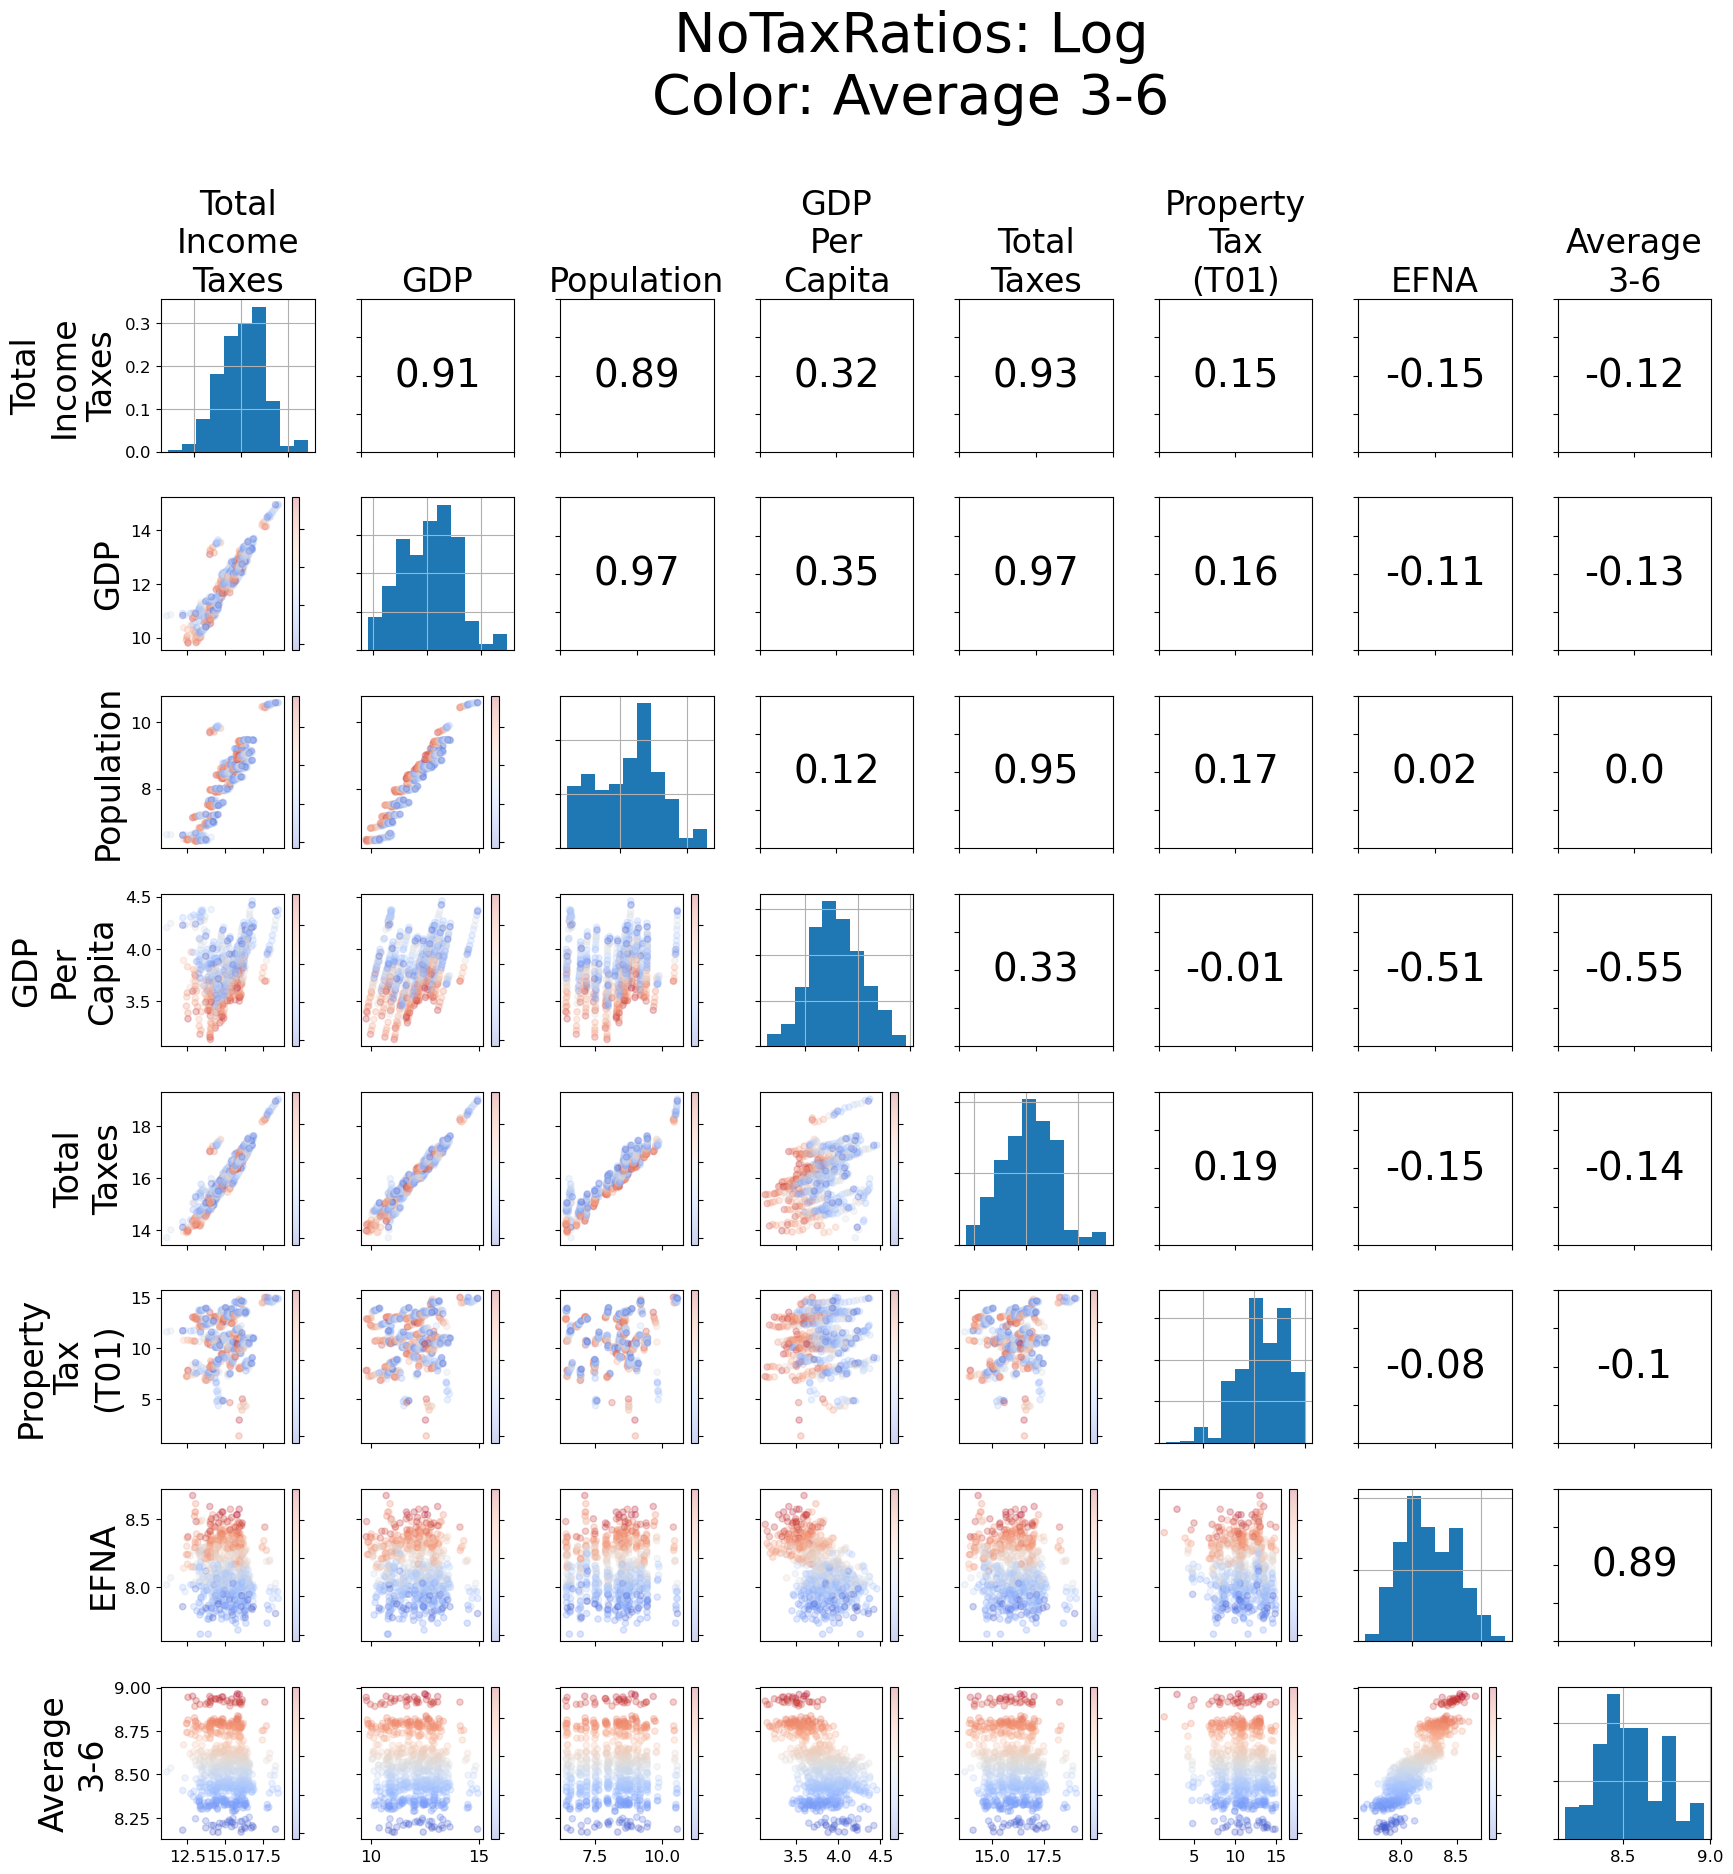

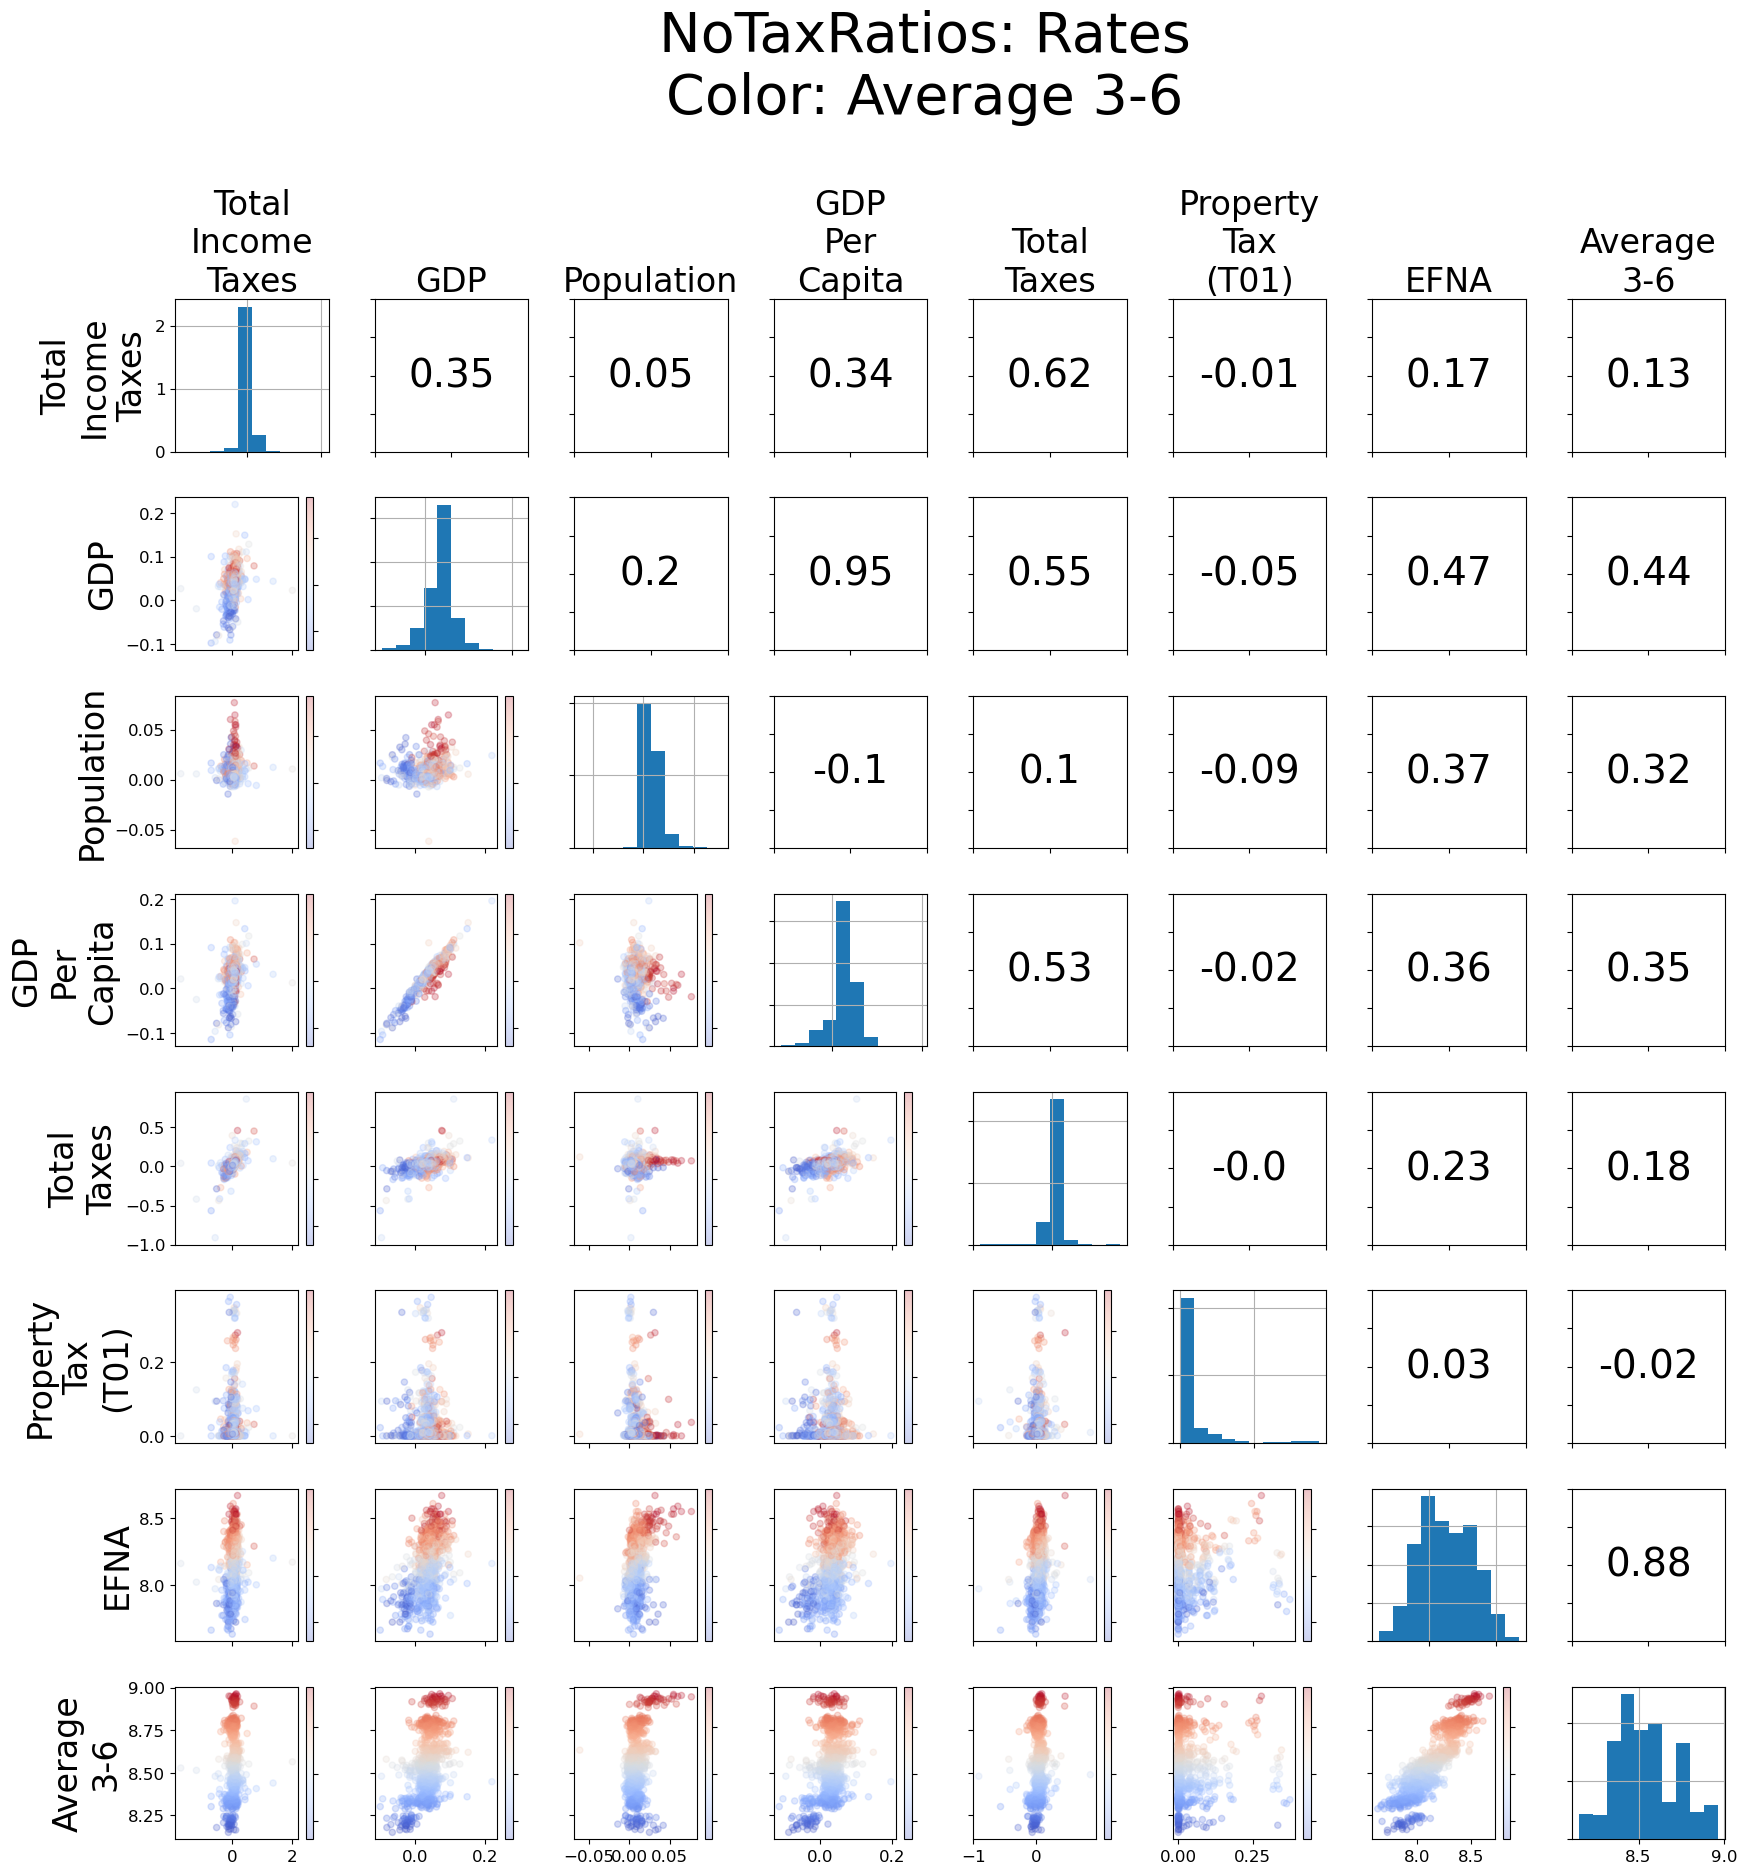

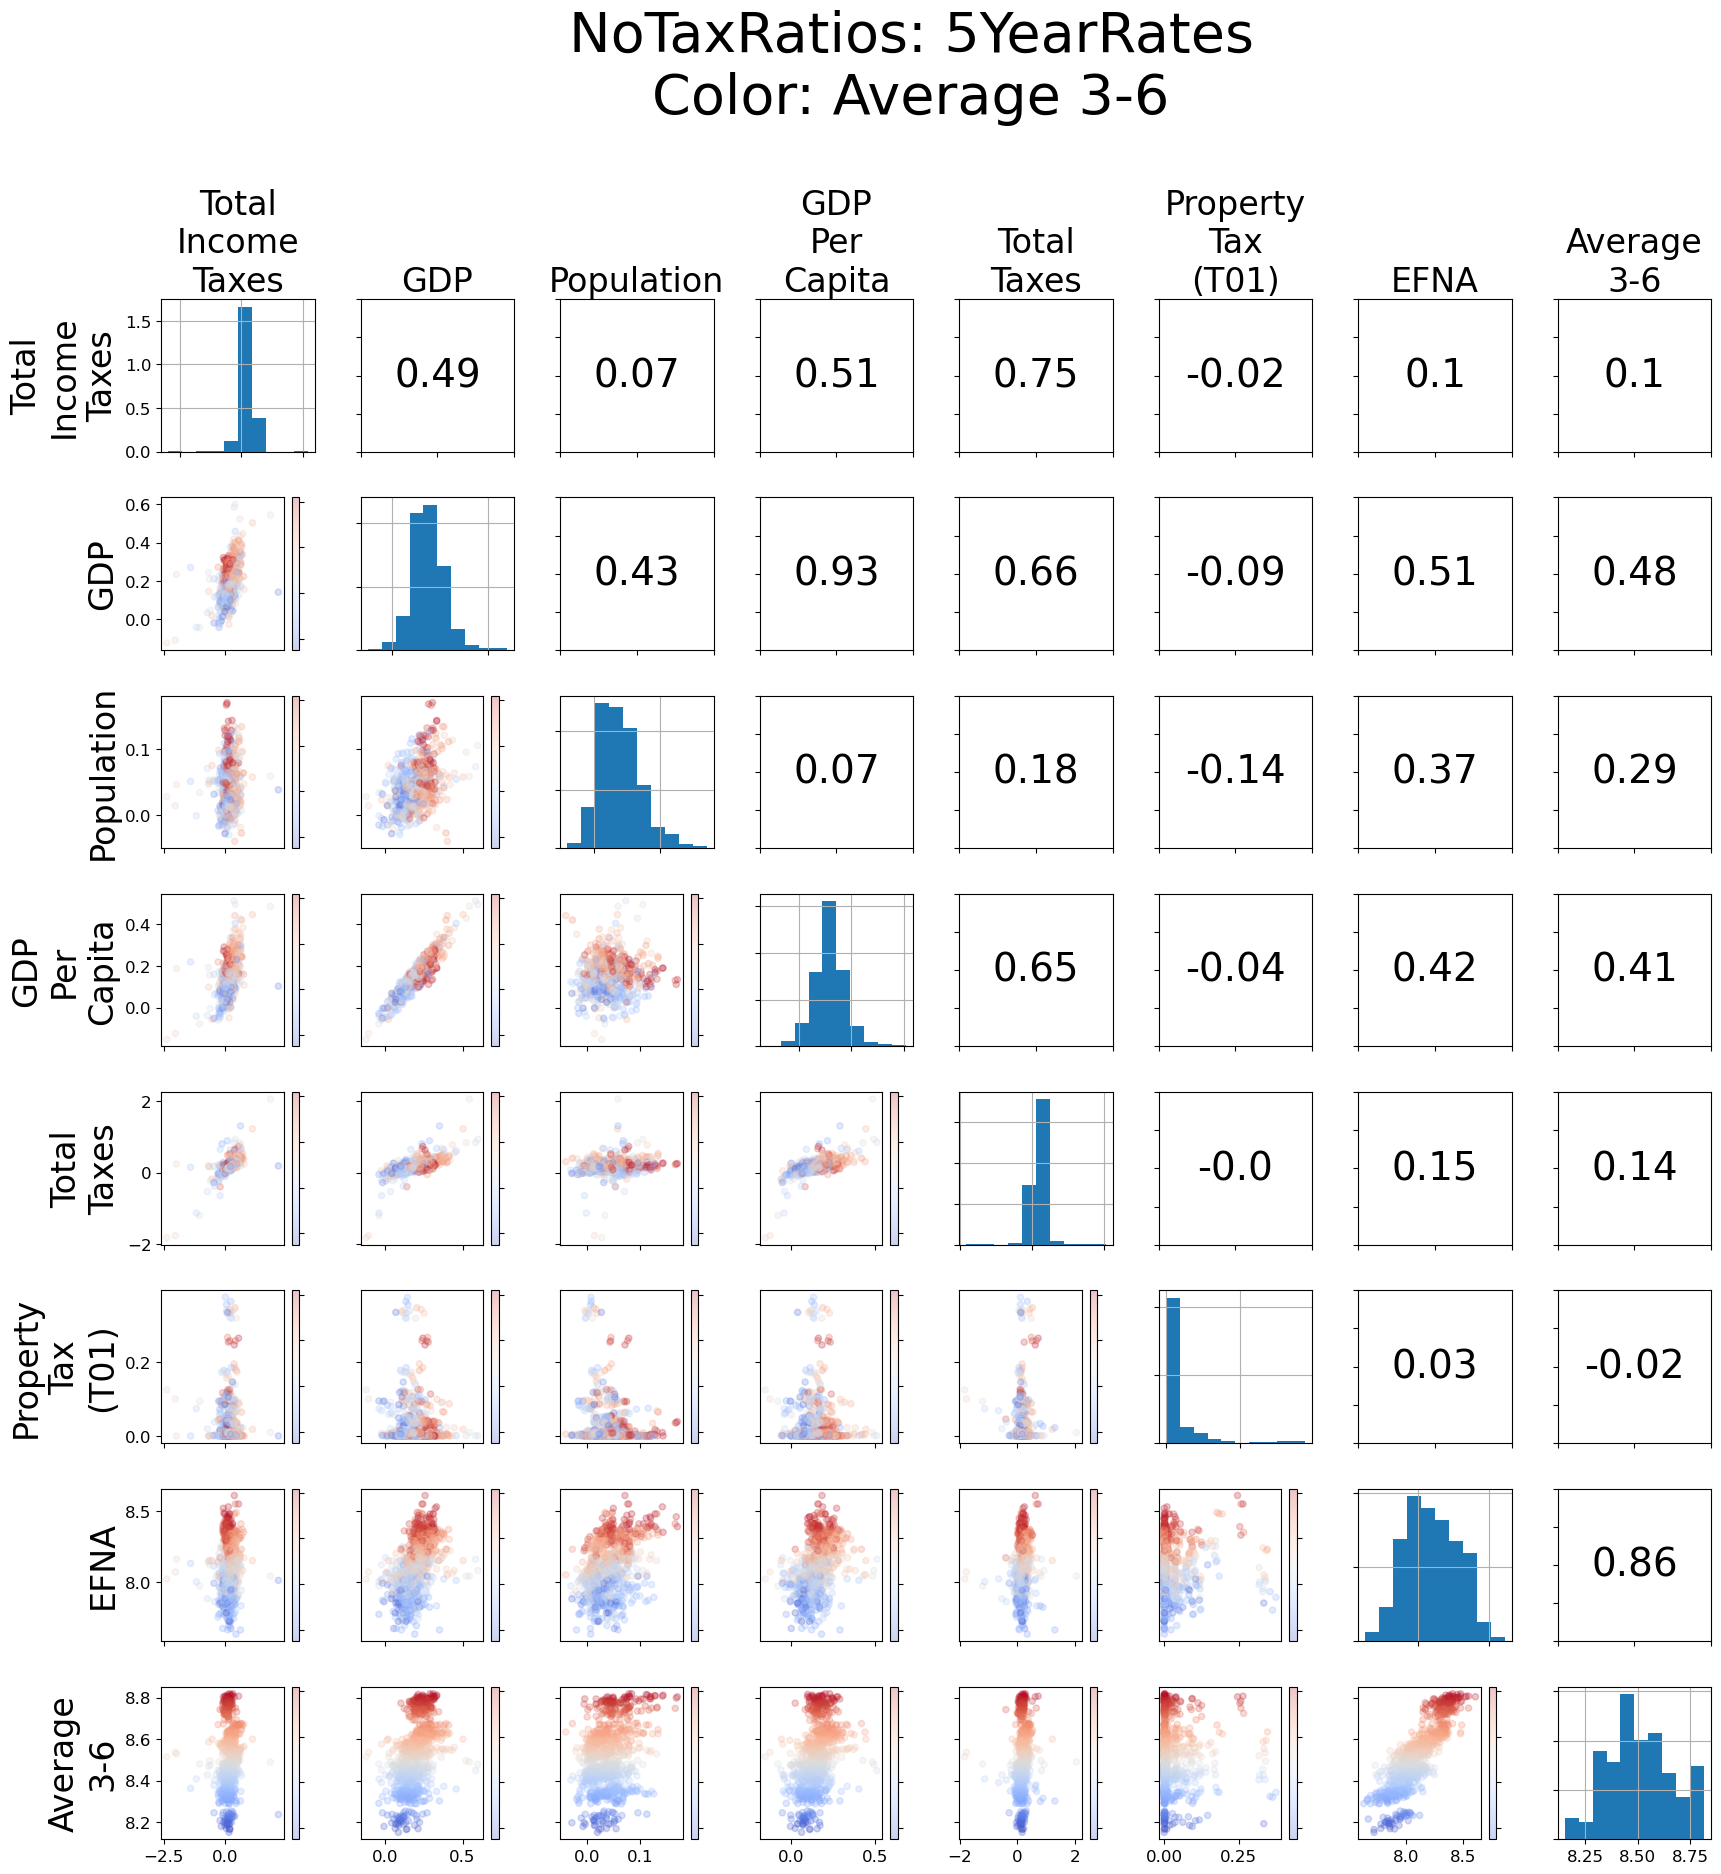

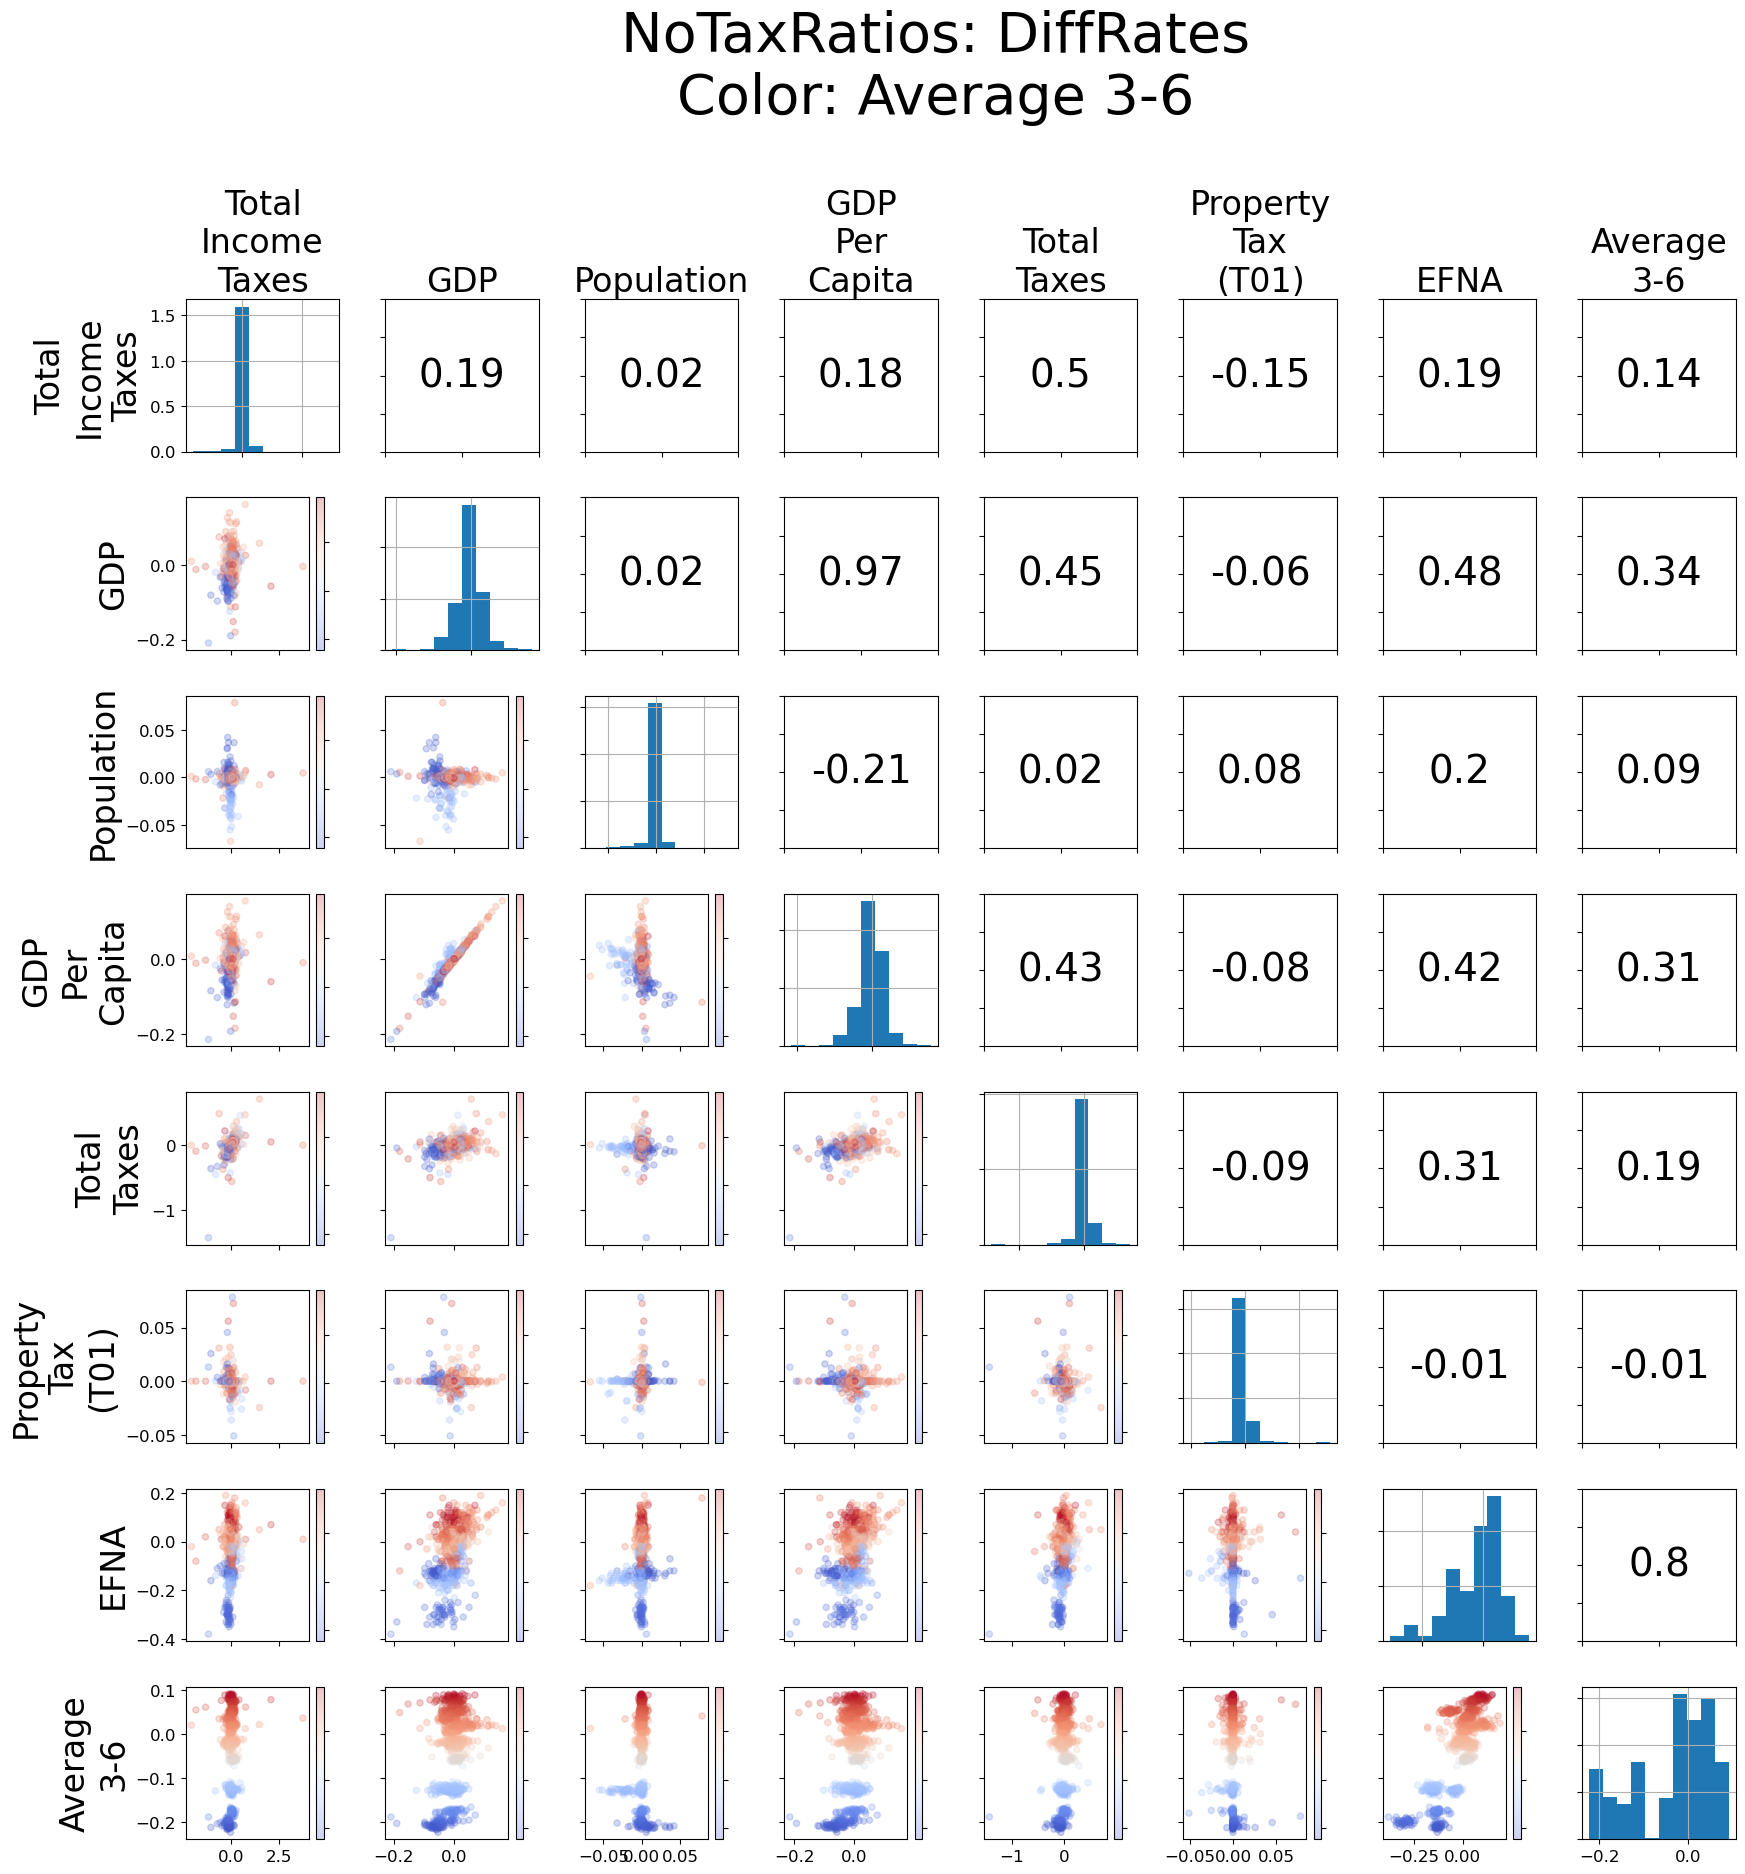

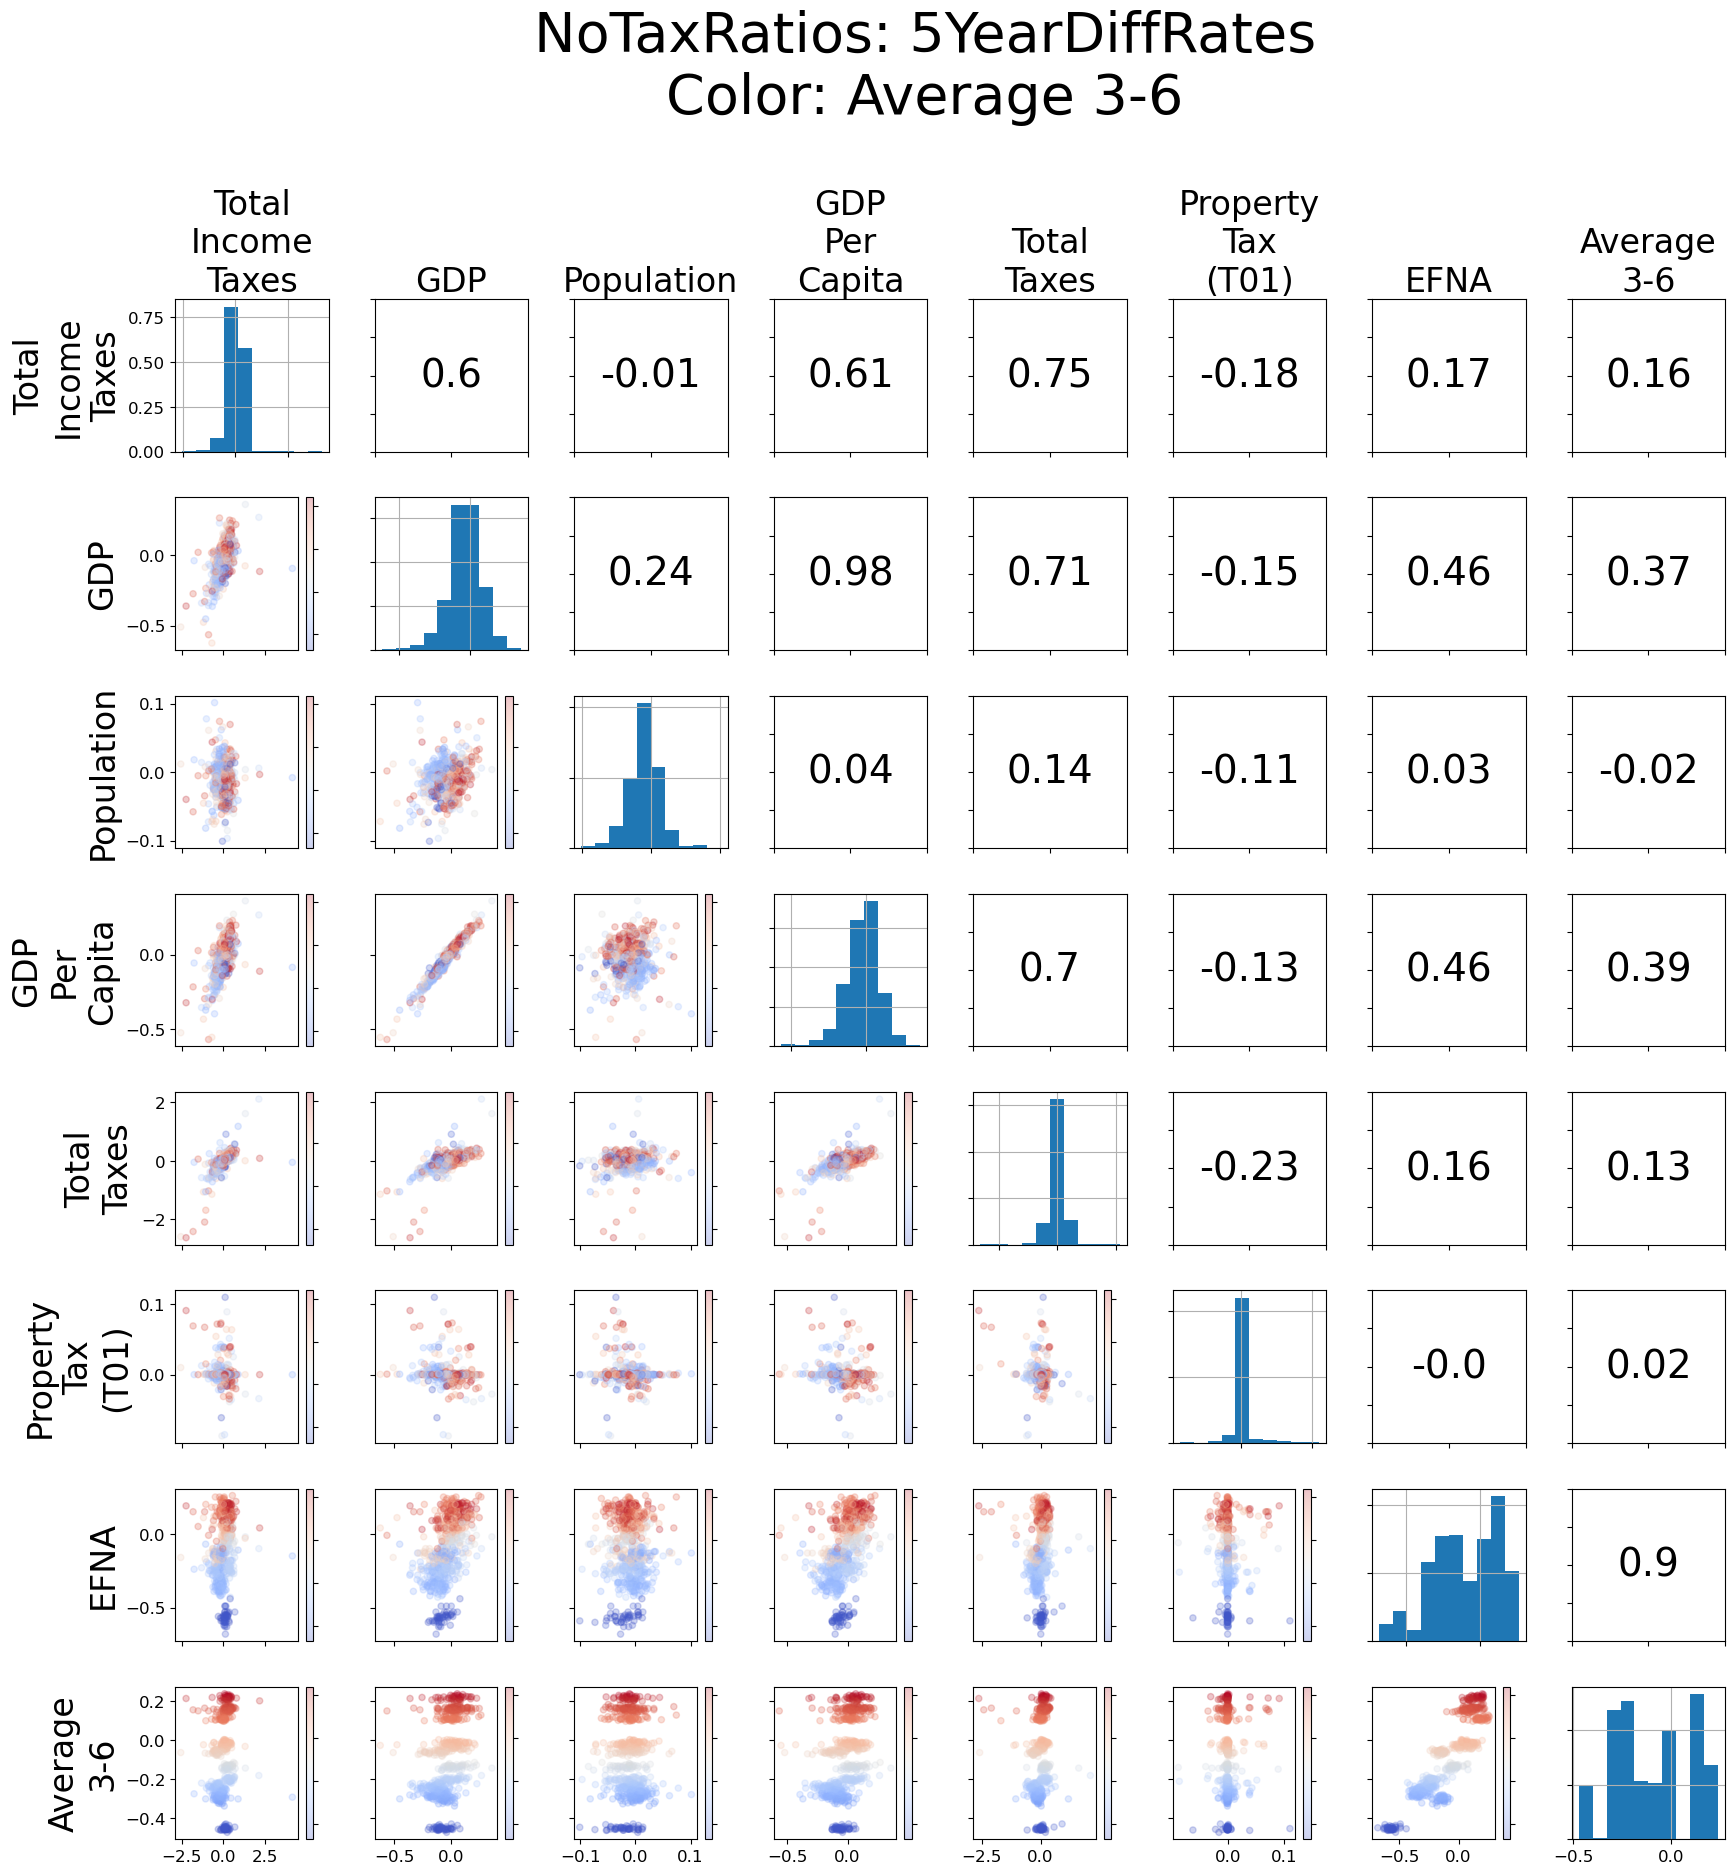

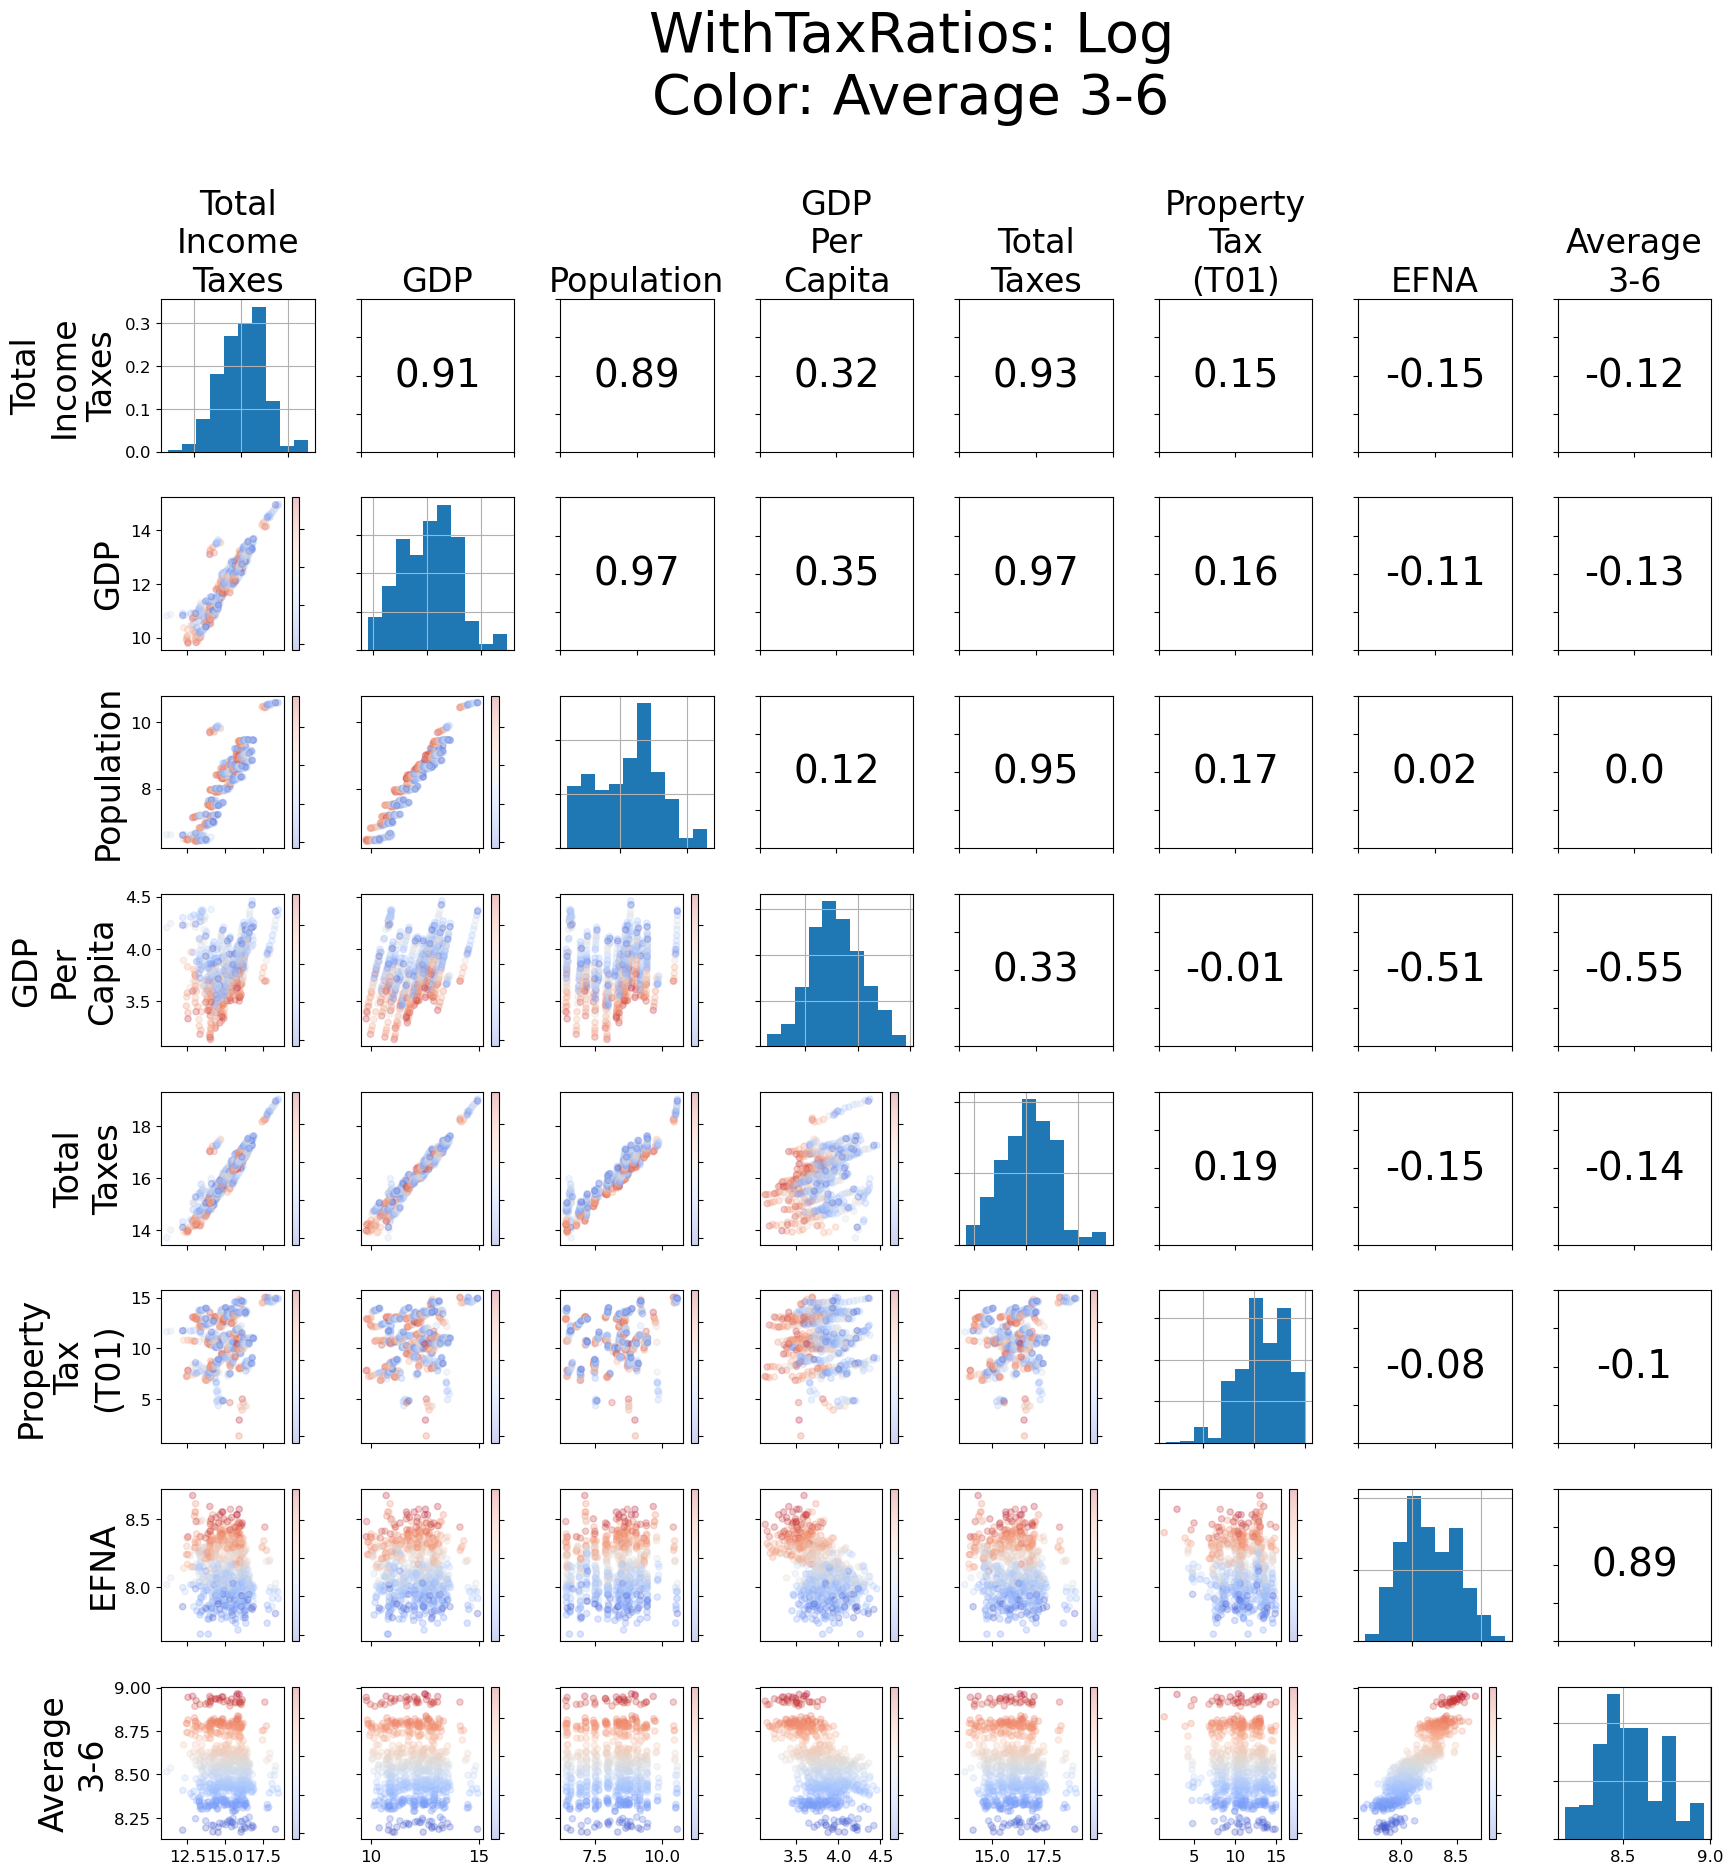

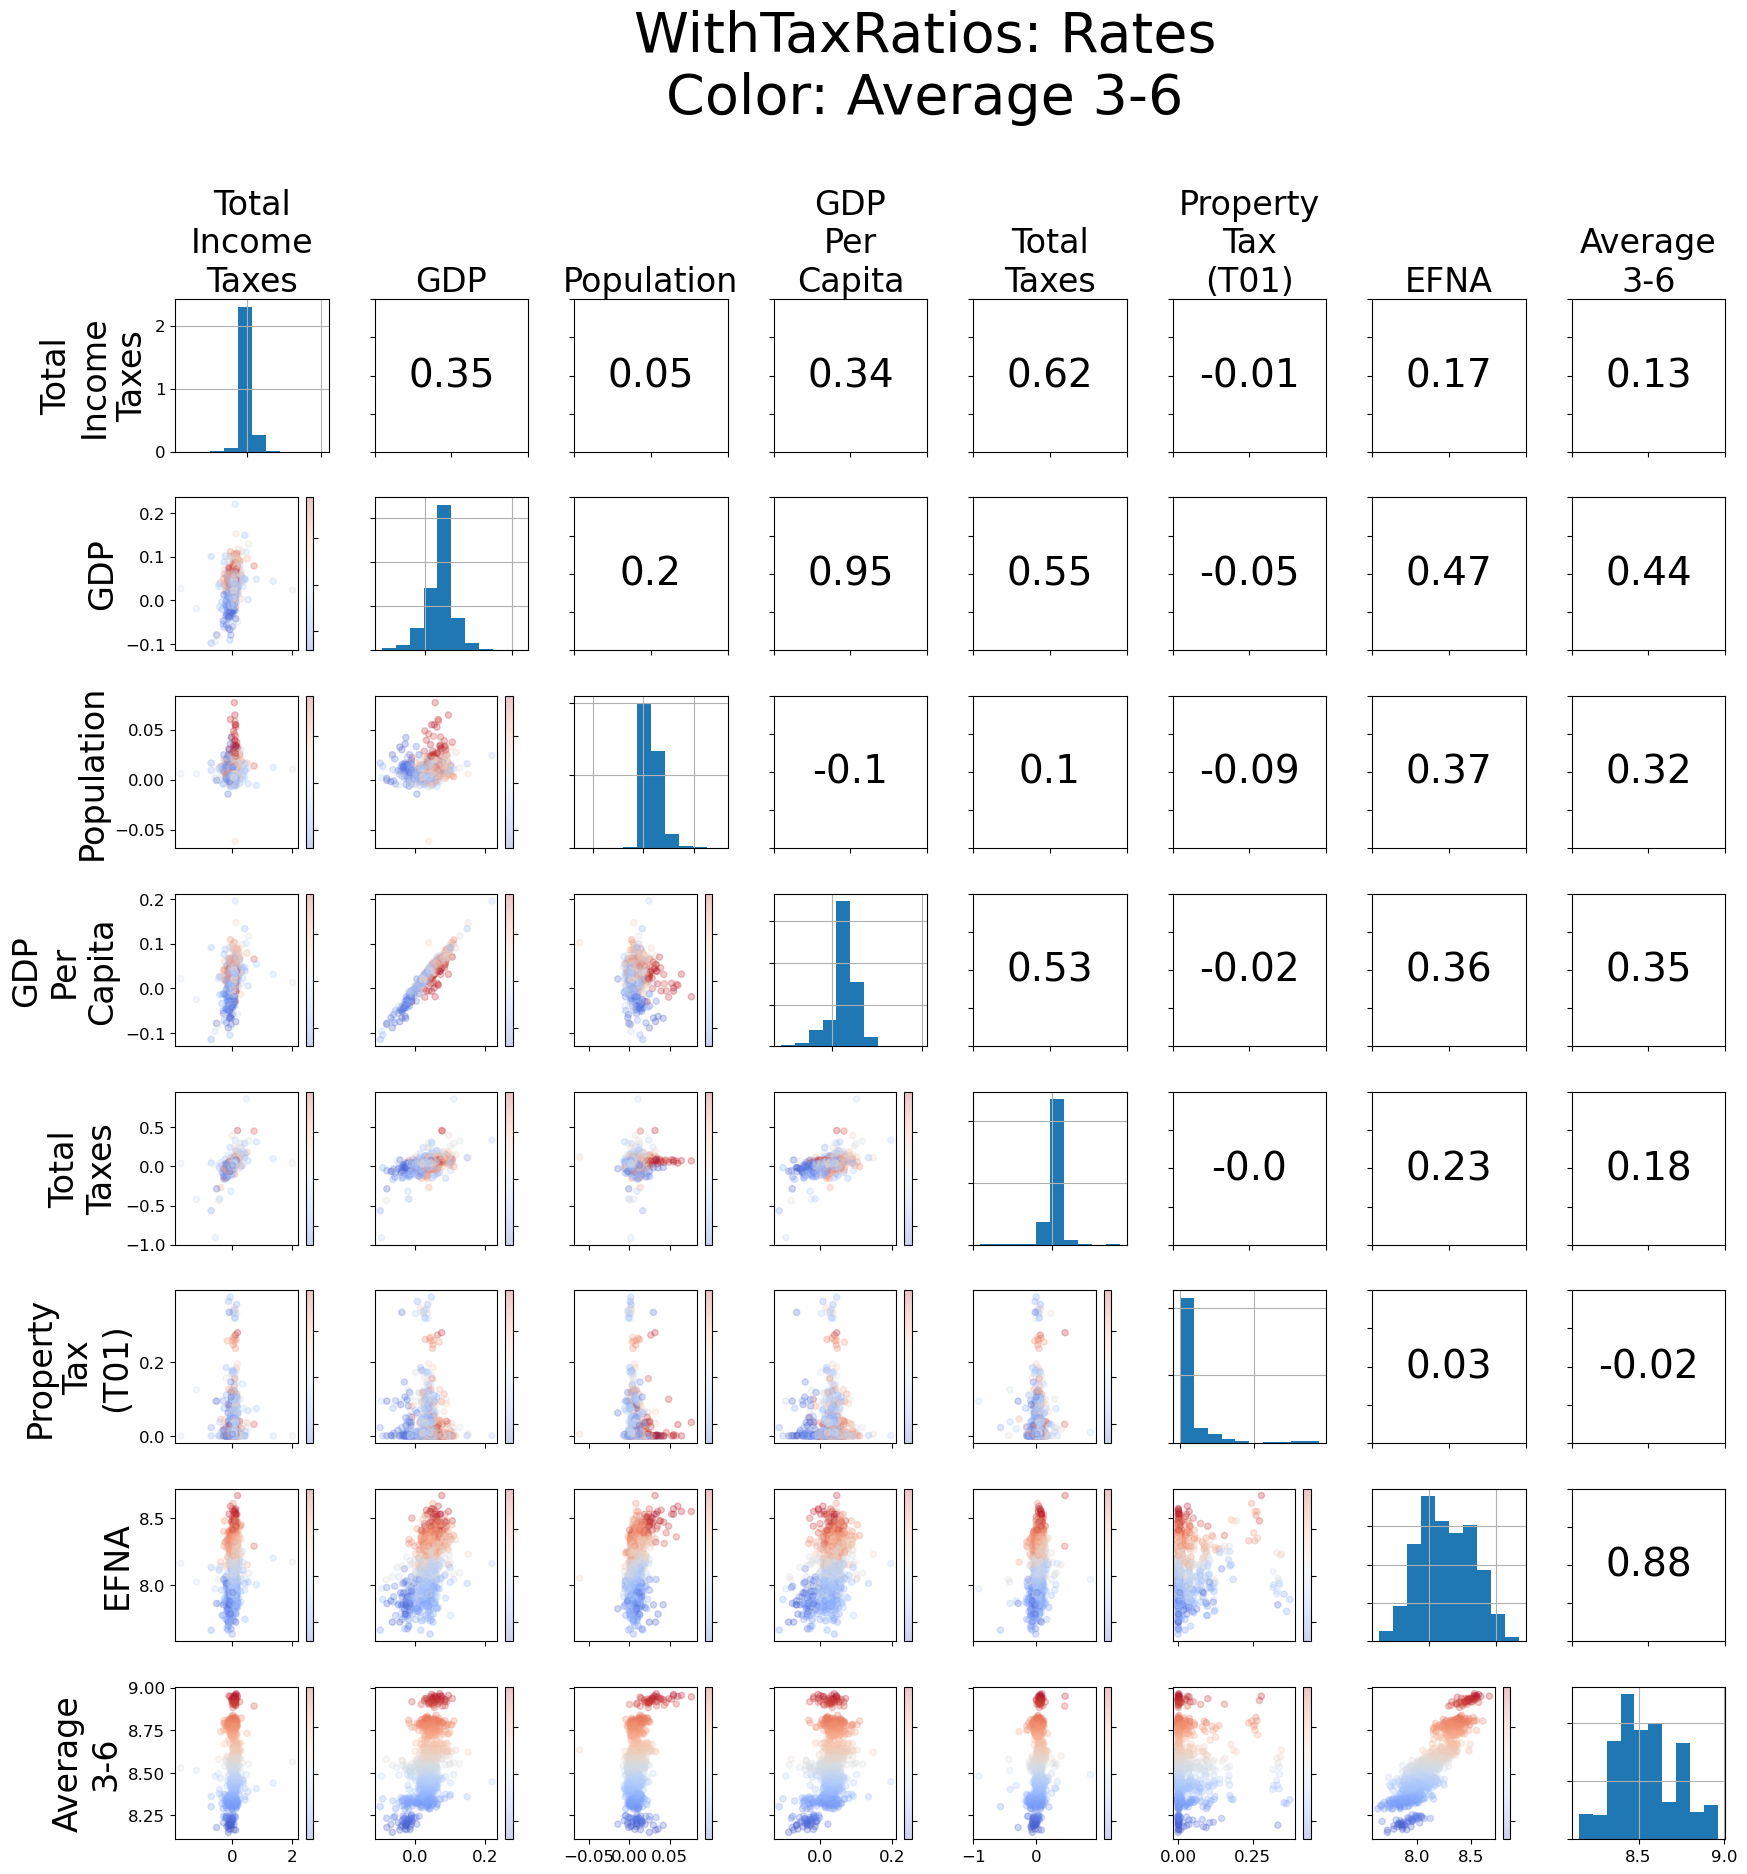

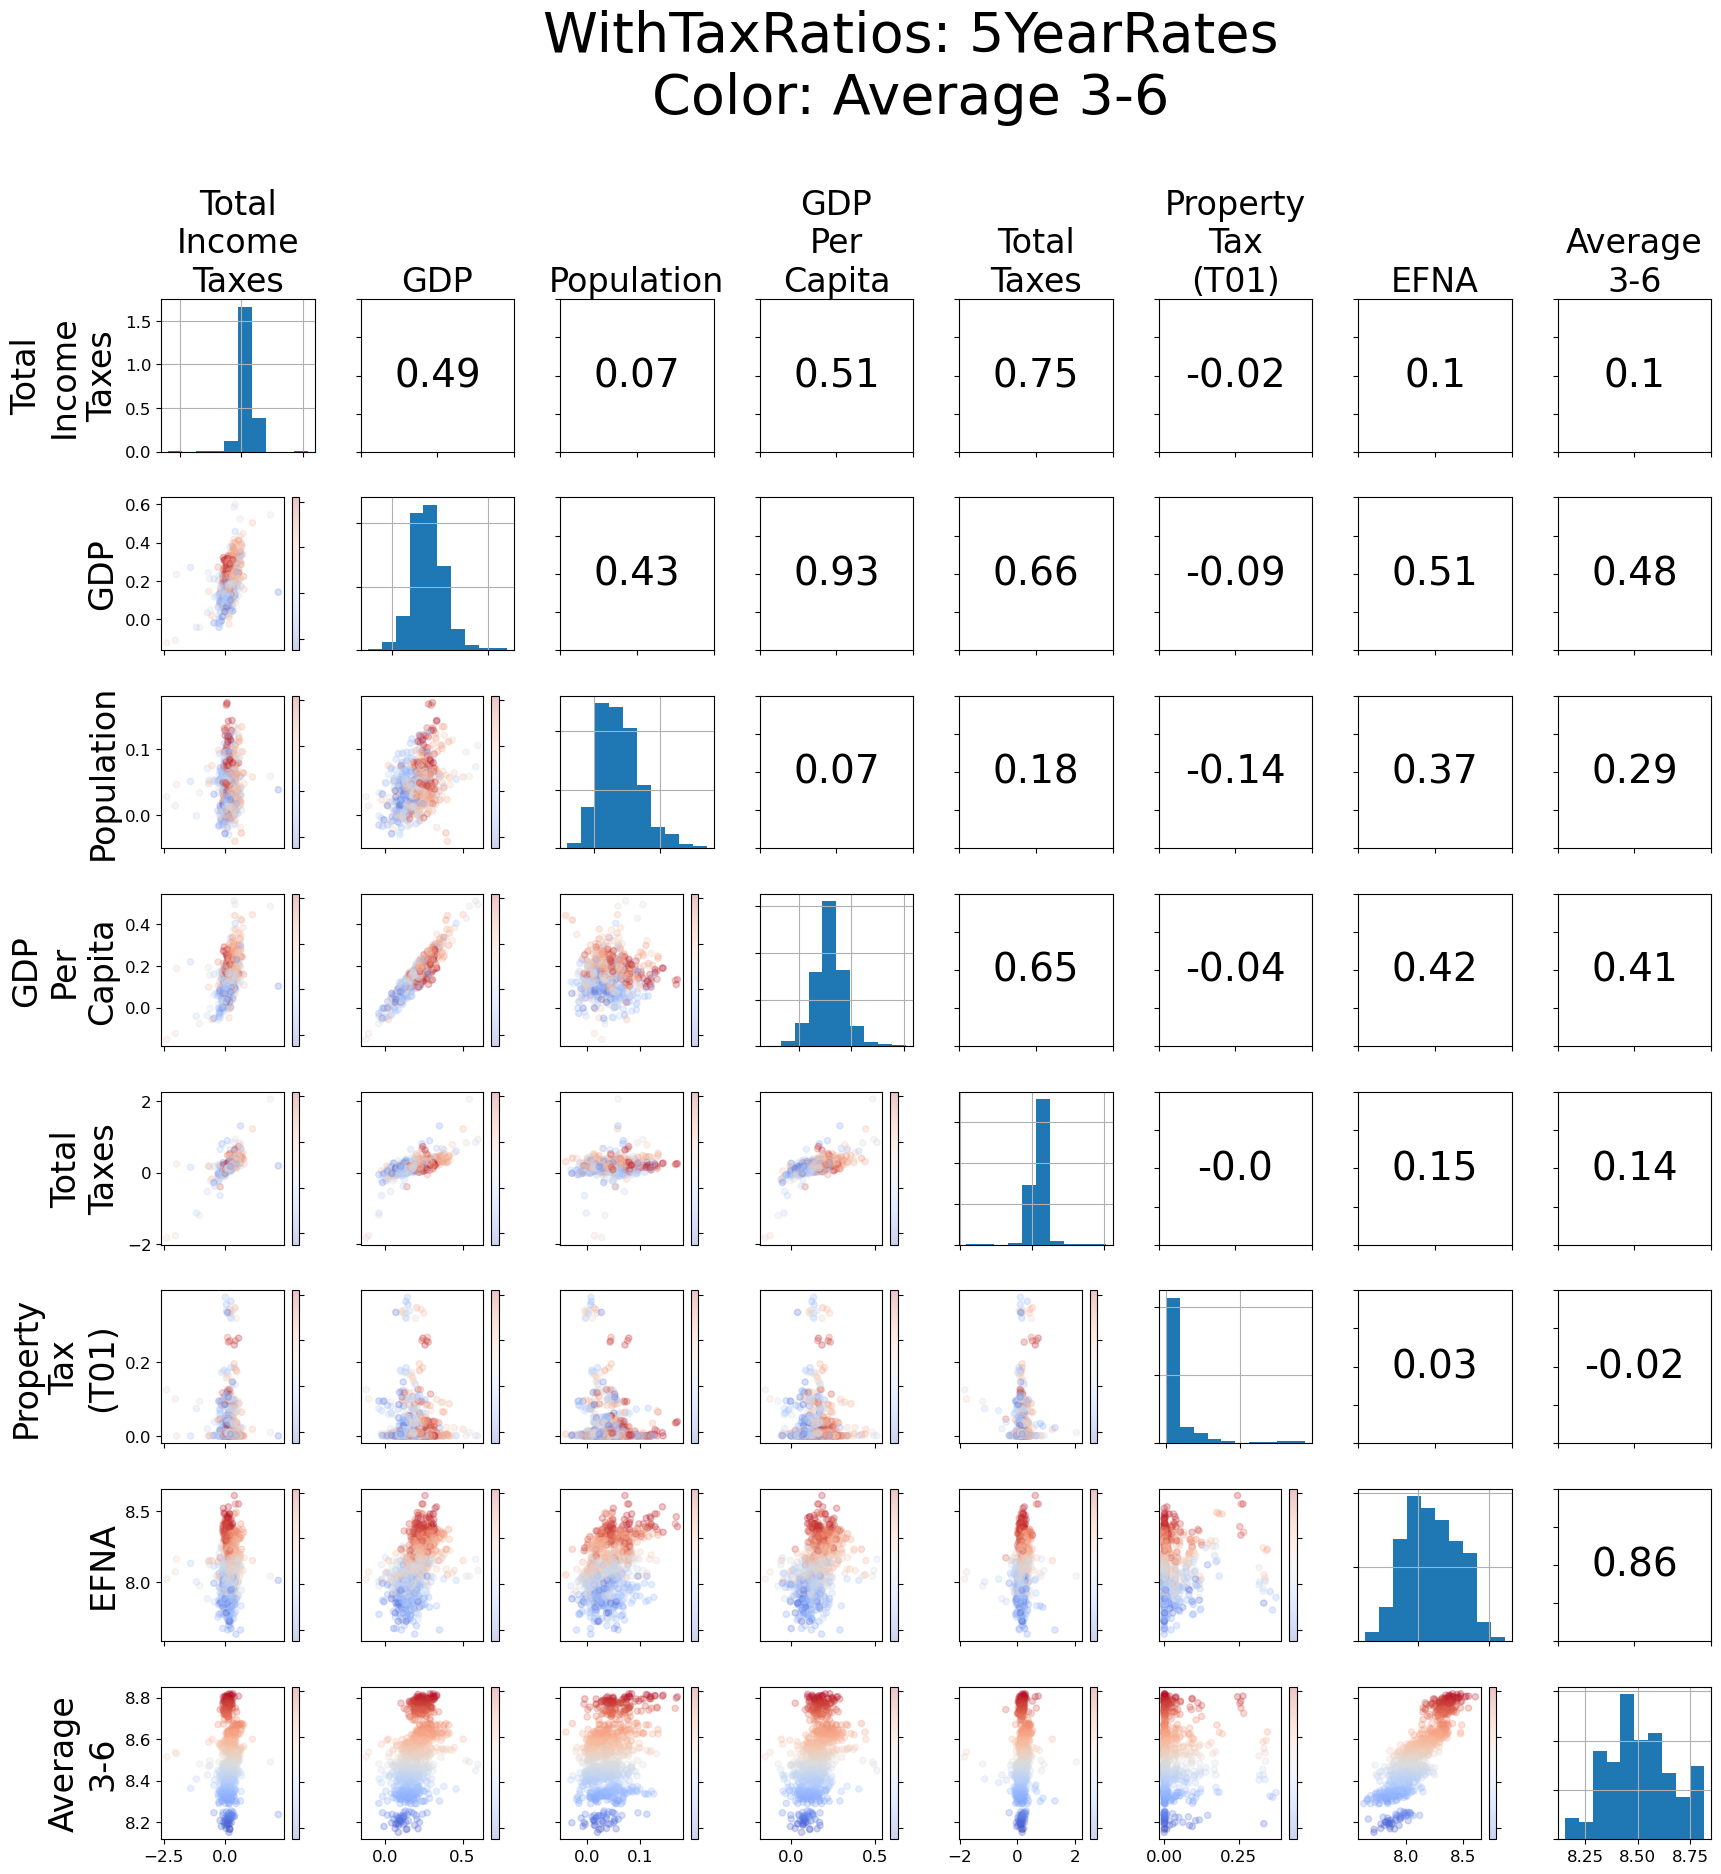

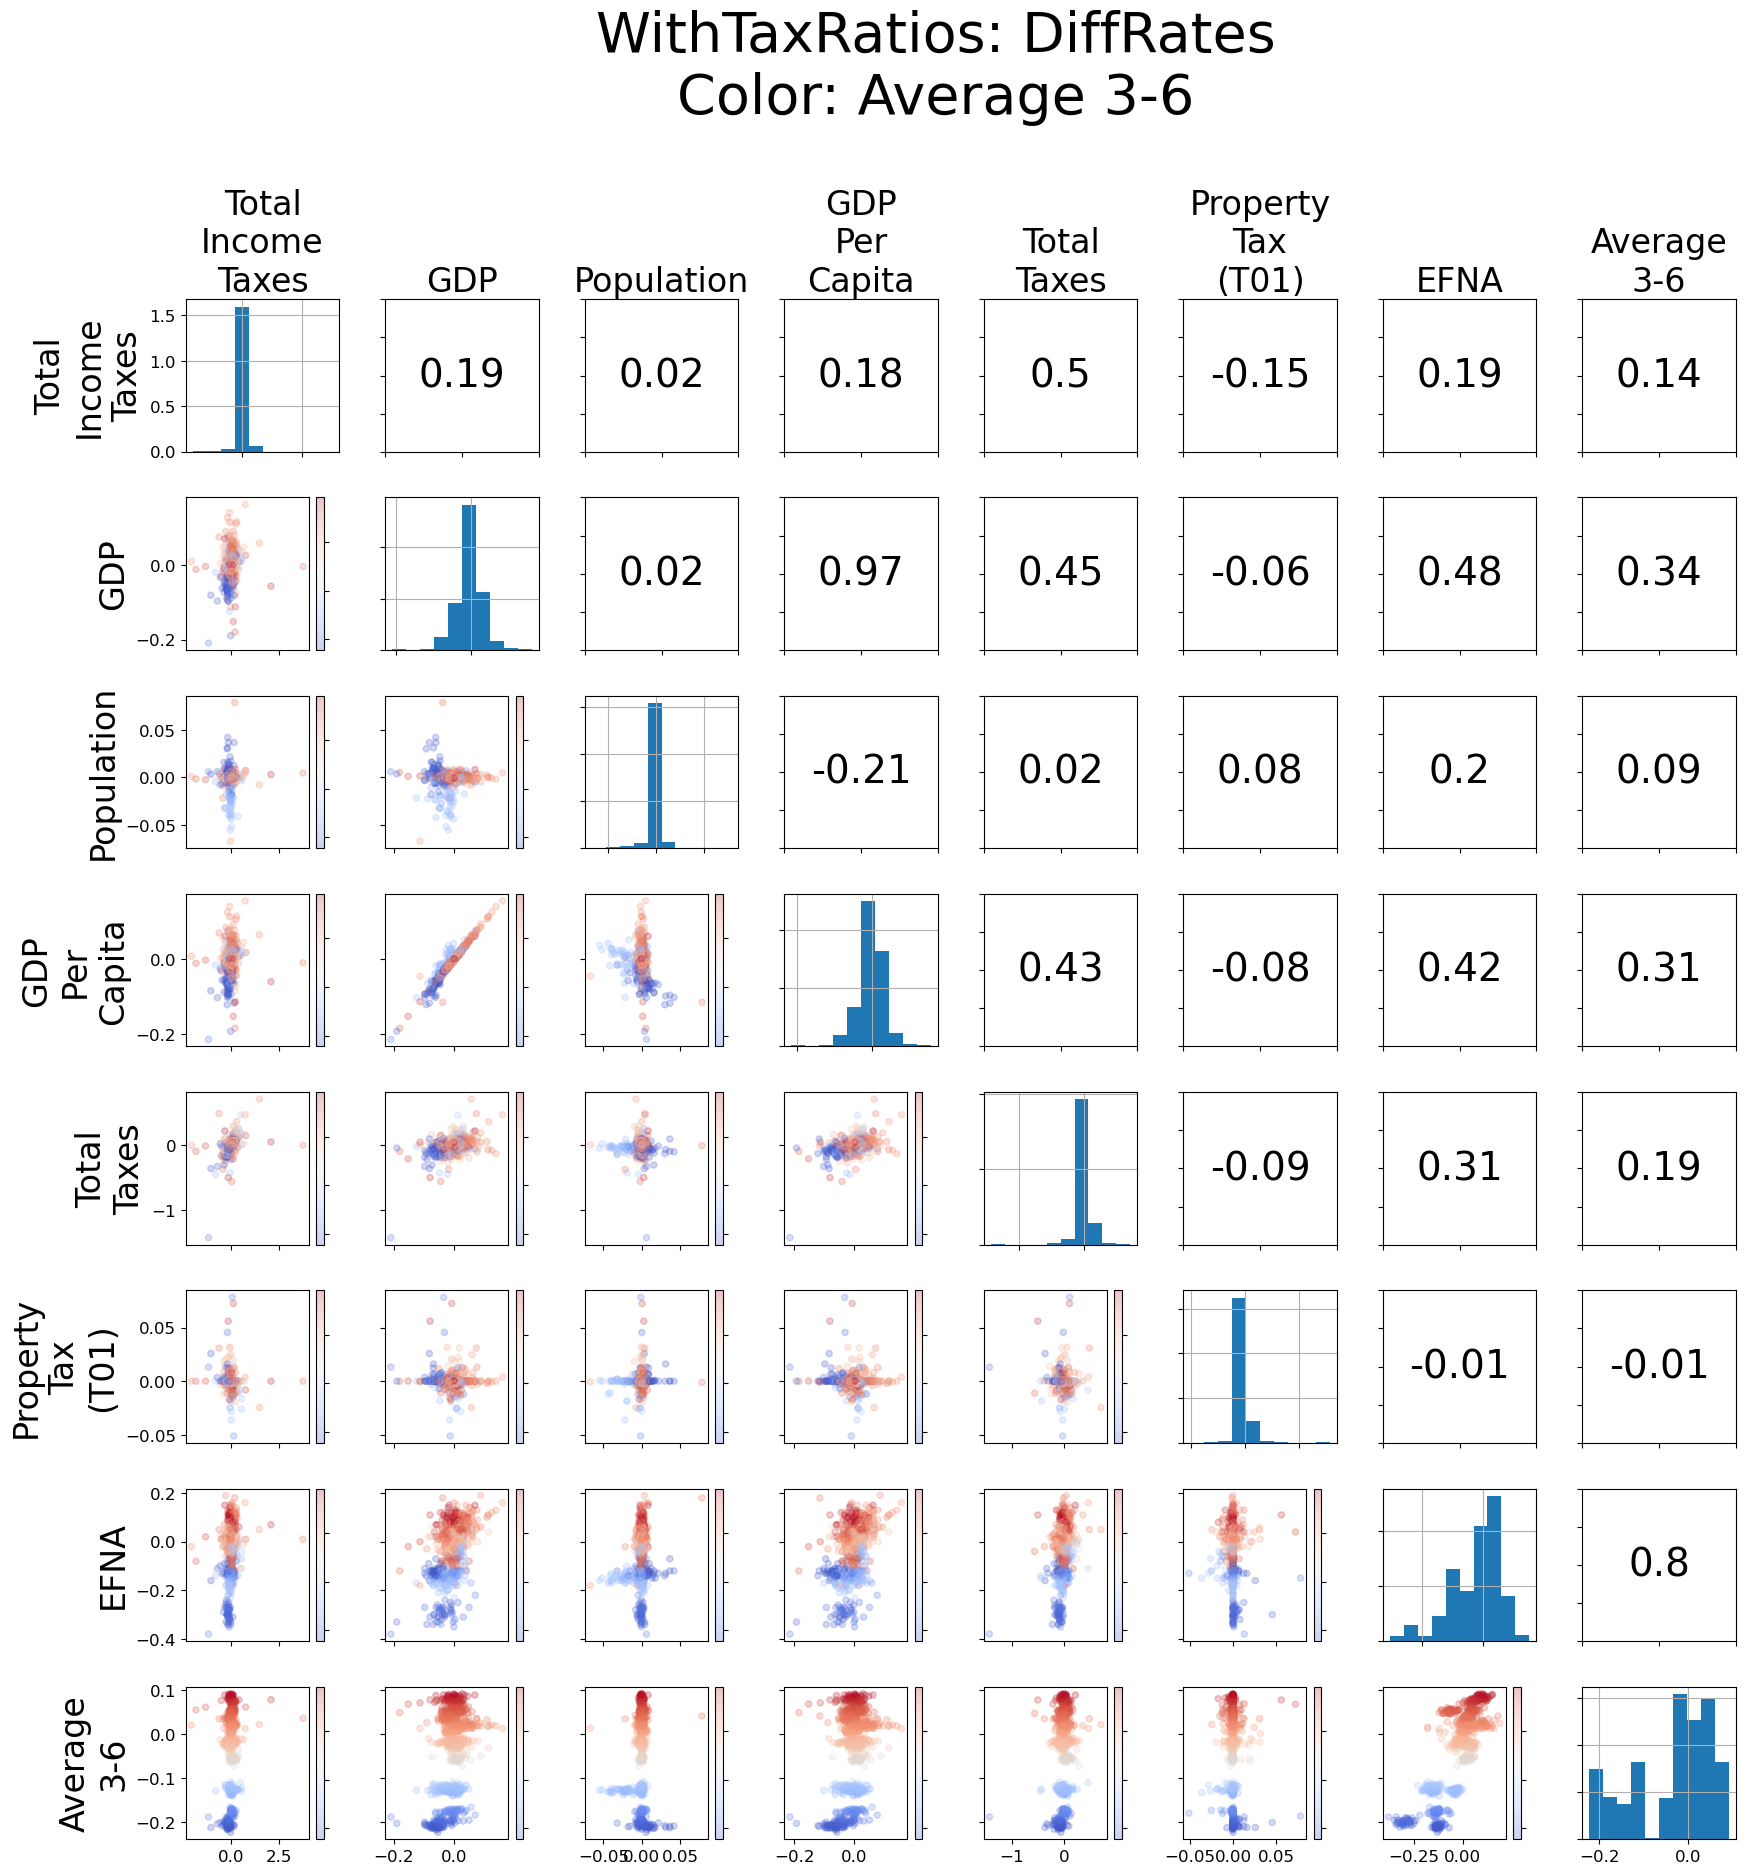

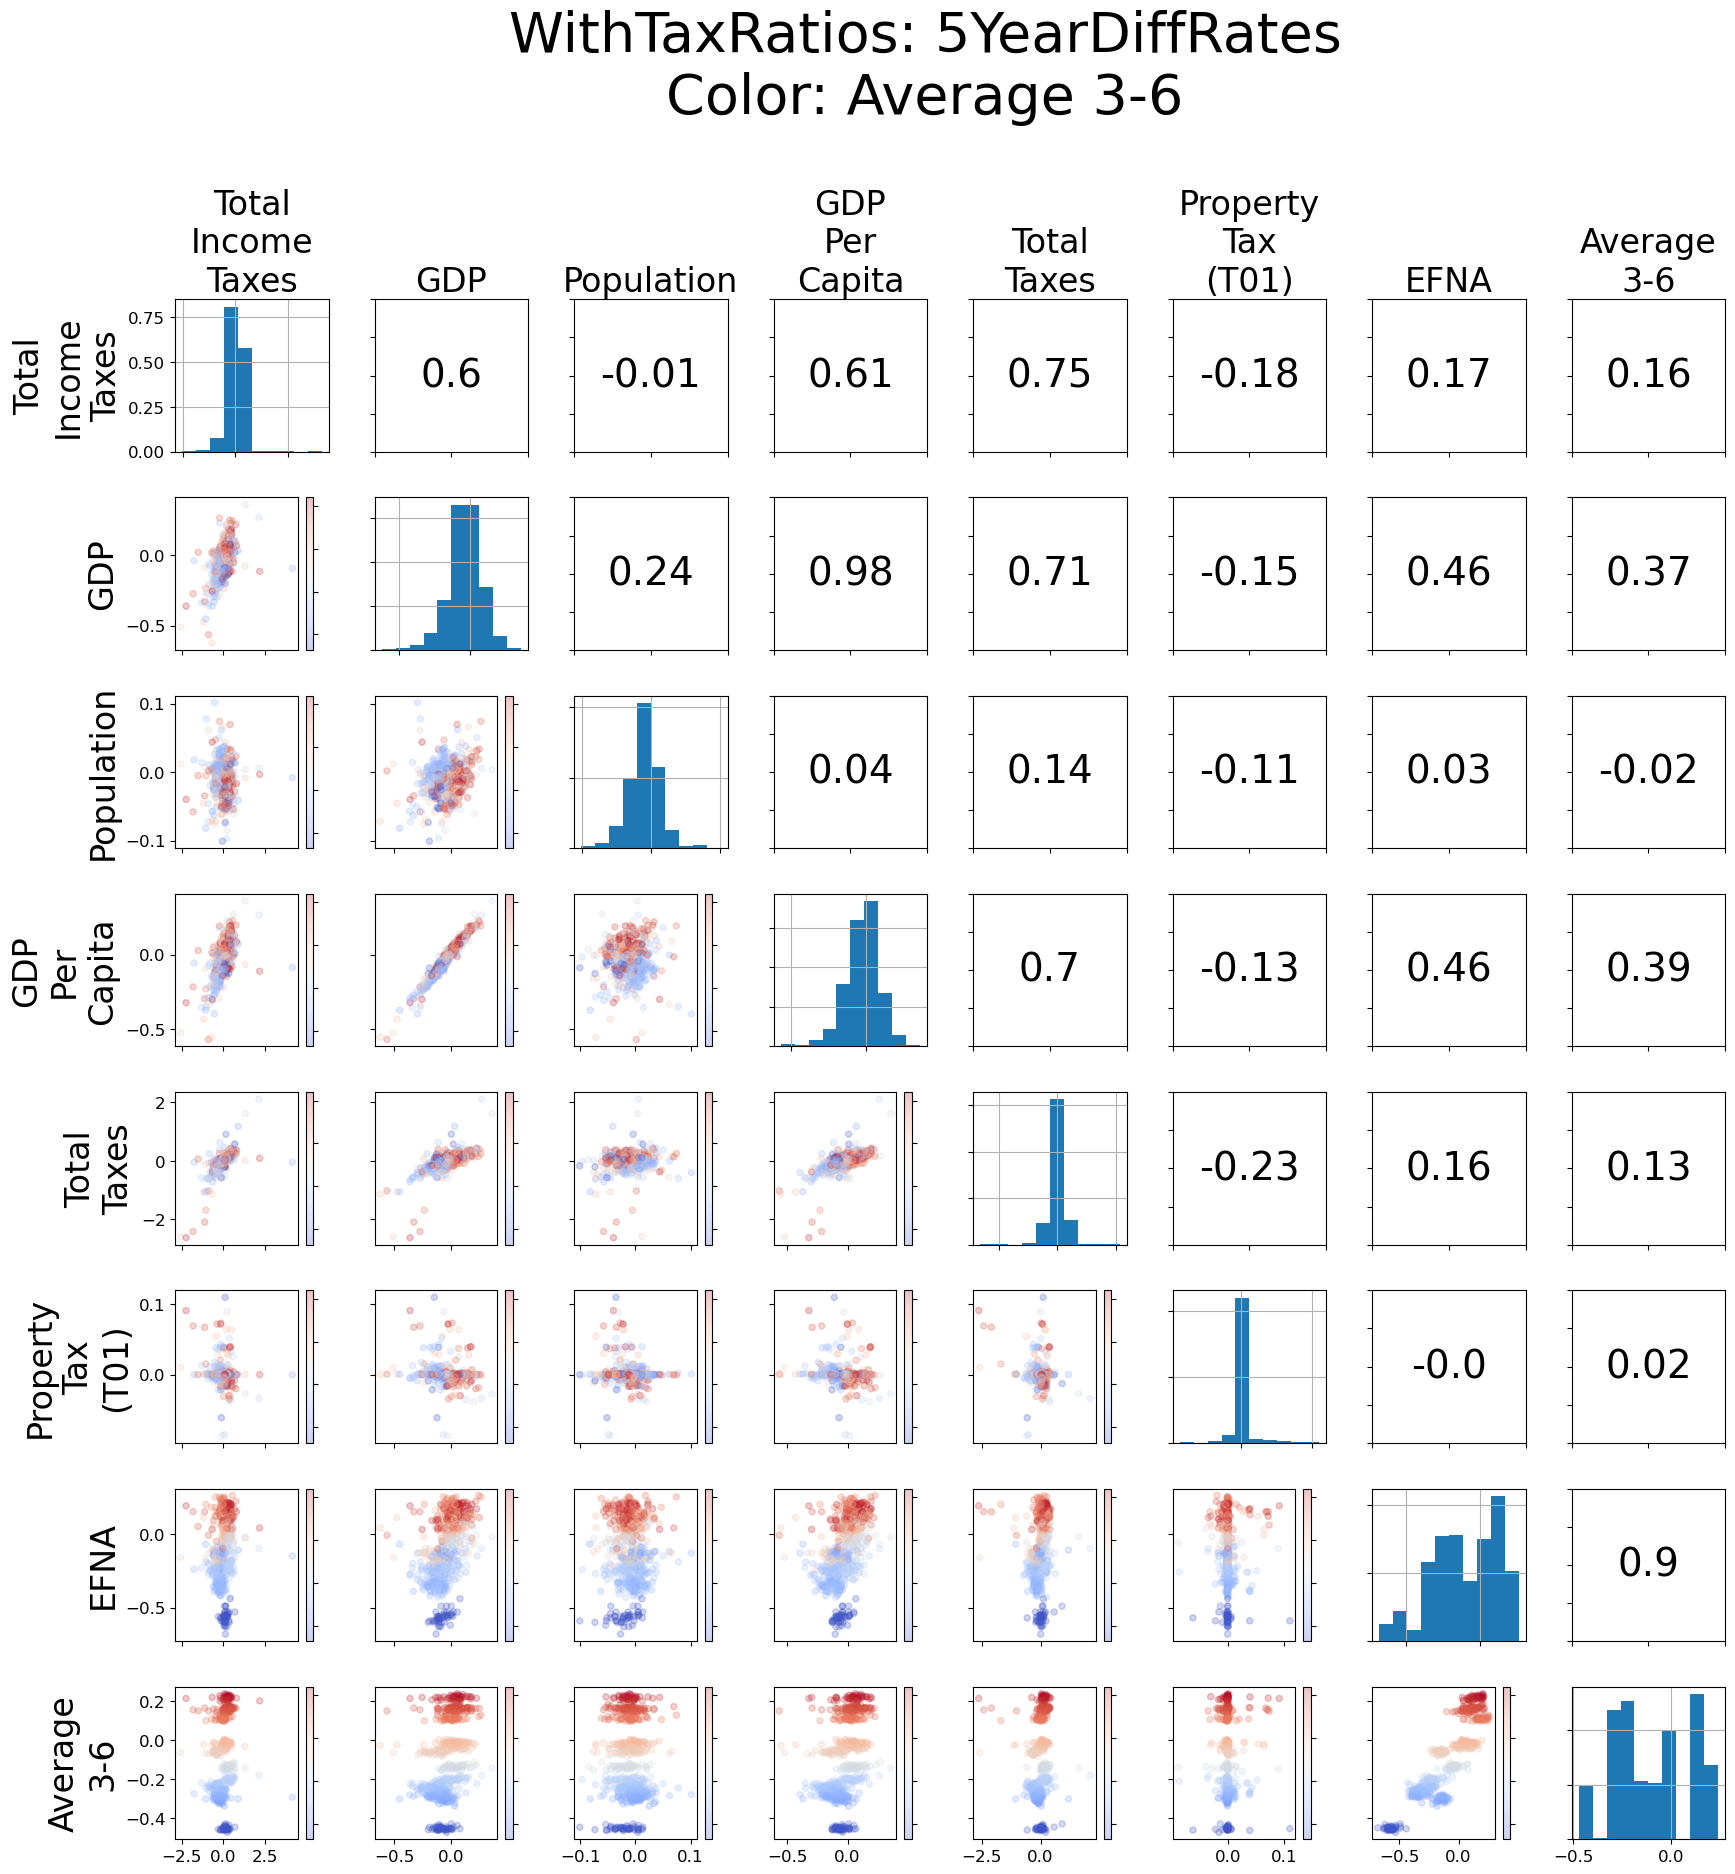

In [7]:
plt.rcParams.update({'font.size': 12})
colors = ["EFNA", "Average 3-6"]
plot_keys = ["Total Income Taxes", "GDP", "Population", "GDP Per Capita",
             "Total Taxes", "Property Tax (T01)", 
         #    "Individual Income Tax (T40)", "Corp Net Income Tax (T41)"
            ] + colors

# Example usage
for variant, dct in list(dfs_dct.items())[:]: 
    for name, df in list(dct.items())[1:]:
    # possible to include tax component levels instead of component by percent of total taxes; 
    #  results of logged components in the least not meaningful without level info
        c ="Average 3-6"
        plot_df = df[plot_keys].dropna()
        fig, ax = plot_scatter_corr(plot_df.dropna(), f"{variant}: {name}\nColor: {c}", corr="corr", alpha =.25, cmap = "coolwarm", c = c)

NoTaxRatios: Log
 Total Taxes
                                      Model Comparison                                      
                               Entity:False,   Entity:False,    Entity:True,    Entity:True,
                                  Time:False       Time:True      Time:False       Time:True
--------------------------------------------------------------------------------------------
Dep. Variable                    Total Taxes     Total Taxes     Total Taxes     Total Taxes
Estimator                           PanelOLS        PanelOLS        PanelOLS        PanelOLS
No. Observations                         763             763             763             763
Cov. Est.                          Clustered       Clustered       Clustered       Clustered
R-squared                             0.9537          0.9552          0.8252          0.5408
R-Squared (Within)                    0.7610         -1.0927          0.8252         -0.8369
R-Squared (Between)                   0.

TypeError: FigureCanvasAgg.print_png() got an unexpected keyword argument 'bbox_to_inches'

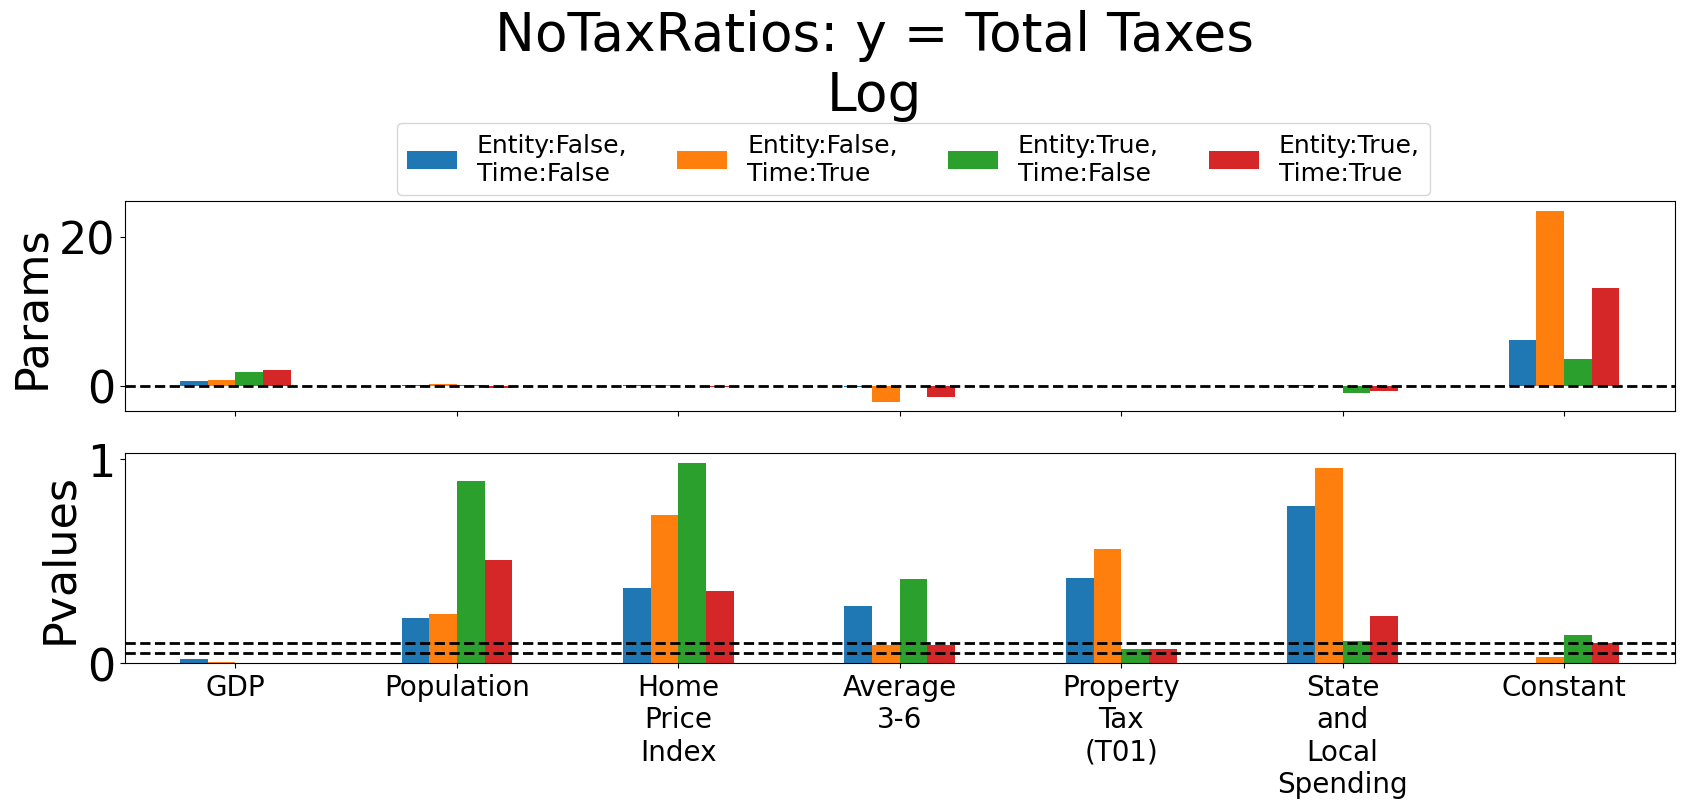

In [8]:
plt.rcParams.update({'font.size': 32})
r2_dict = {}
results_dict = {}
beta_dict = {}
pval_dict = {}

reg_vars = ["GDP", "Population", "Total Taxes", "Home Price Index",
            "Average 3-6", "Property Tax (T01)", "State and Local Spending"]
ic = info_criterion()
# possible to include tax component levels instead of component by percent of total taxes; 
#  results of logged components in the least not meaningful without level info
for variant, dct in list(dfs_dct.items())[:]:
    for key, df in list(dct.items())[1:]:
        results_dict[key] = {}
        r2_dict[key] = {}
        beta_dict[key] = {}
        pval_dict[key] = {}
        # fig, ax = plt.subplots(2,2, figsize = (20,20))
        for y_name in ["Total Taxes", "GDP", "State and Local Spending", "Property Tax (T01)"]:
            r2_dict[key][y_name] = {}
            results_dict[key][y_name] = {}
            beta_dict[key][y_name] = {}
            pval_dict[key][y_name] = {}
            X_names = [name for name in reg_vars if name != y_name]
            for i, entity in enumerate([False, True]):
                for j, time in enumerate([False, True]):
                    beta_dict[key][y_name] = {}
                    pval_dict[key][y_name] = {}
                    reg_data = df[reg_vars].dropna()
                    Y = reg_data[[y_name]]
                    X = reg_data[X_names]
                    if "Diff" not in key:
                        X["Constant"] = 1
                    n = reg_data.shape[1]
                    k = len(X)
                    # call panel_regression method
                    model = PanelOLS(Y,X, entity_effects=entity, time_effects=time)
                    # print(f"Data: {key} y={y_name}\n Entity: {entity}\nTime: {time}")
                    results_dict[key][y_name][f"Entity:{entity},\nTime:{time}"]  = model.fit(cov_type='clustered', cluster_entity=True)
                    results = results_dict[key][y_name][f"Entity:{entity},\nTime:{time}"]
                    r2_dict[key][y_name][f"Entity:{entity},\nTime:{time}"] = {}
                    r2s = ('rsquared', 'rsquared_between', 'rsquared_within')
                    for r2 in r2s:
                        r2_dict[key][y_name][f"Entity:{entity},\nTime:{time}"][r2] = getattr(results, r2)
                    # print(results)
            print(f"{variant}: {key}\n",y_name)
            compare_regs = compare(results_dict[key][y_name])
            print(compare_regs)
            compfig, compax = compare_regs_plot(compare_regs, y_name, variant = variant, title = f"y = {y_name}\n{key}")
            compfig.savefig(f"outputs/{y_name}{variant}Params.png", bbox_inches = "tight")
        # for r2 in r2s:
        #     print(r2df)
        #     r2_index = r2df.loc[r2] >0
    
        #     r2df = r2df[r2df.loc[r2] >0]
        # Convert the dictionary to a list of tuples
        data_tuples = [(outer_key, inner_key, k, v) for outer_key, inner_dict in r2_dict[key].items() for inner_key, inner_inner_dict in inner_dict.items() for k, v in inner_inner_dict.items()]
        
        # Convert the list of tuples to a pandas DataFrame
        r2_df = pd.DataFrame(data_tuples, columns=[ 'y', 'Effects', 'r2',  'Value']).sort_values(["r2", "y"])
        
        # Set the multi-level index
        r2_df = r2_df.pivot(index = ["r2", "y"], columns = "Effects", values = "Value").reset_index()
        r2fig, r2ax = plot_r2(r2_df, r2s, key,variant)
        r2fig.savefig(f"outputs/{y_name}{variant}R2s.png", bbox_inches = "tight")

In [4]:
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio

# Define the plotting functions using Plotly
def plot_scatter_corr(data, x, y, title):
    fig = px.scatter(data, x=x, y=y, trendline='ols')
    fig.update_layout(title=title)
    return fig

def plot_r2(data, x, y, title):
    fig = go.Figure()
    fig.add_trace(go.Bar(x=x, y=y))
    fig.update_layout(title=title)
    return fig

def compare_regs_plot(data, x, y, title):
    fig = go.Figure()
    fig.add_trace(go.Bar(x=x, y=y))
    fig.update_layout(title=title)
    return fig

# Extract variables and models from the existing script context
dependent_variables = ["Total Income Taxes", "GDP", "Population", "GDP Per Capita",
                       "Total Taxes", "Property Tax (T01)", "Average 3-6"]
models = list(dfs_dct.keys())

# Create a function to generate interactive HTML
def create_interactive_html(dfs_dct, output_file):
    fig = go.Figure()

    # Dropdown menus for models and dependent variables
    fig.update_layout(
        updatemenus=[
            {
                'buttons': [
                    {'label': model, 'method': 'update', 'args': [{'visible': [model == m for m in models]}]}
                    for model in models
                ],
                'direction': 'down',
                'showactive': True,
                'x': 0.17,
                'xanchor': 'left',
                'y': 1.1,
                'yanchor': 'top'
            },
            {
                'buttons': [
                    {'label': var, 'method': 'update', 'args': [{'visible': [var == v for v in dependent_variables]}]}
                    for var in dependent_variables
                ],
                'direction': 'down',
                'showactive': True,
                'x': 0.3,
                'xanchor': 'left',
                'y': 1.1,
                'yanchor': 'top'
            }
        ]
    )

    # Add scatter plots and bar plots to the figure
    for model, dct in dfs_dct.items():
        for name, df in dct.items():
            for var in dependent_variables:
                if var in df.columns:
                    # Scatter plot
                    scatter_fig = plot_scatter_corr(df, 'EFNA', var, f'Scatter Plot {model}: {name} vs {var}')
                    for trace in scatter_fig['data']:
                        fig.add_trace(trace)

                    # Bar plot for R2 values
                    r2_fig = plot_r2(df, df.index, df[var], f'R2 Values {model}: {name} vs {var}')
                    for trace in r2_fig['data']:
                        fig.add_trace(trace)

                    # Bar plot for parameter estimates
                    reg_fig = compare_regs_plot(df, df.index, df[var], f'Parameter Estimates {model}: {name} vs {var}')
                    for trace in reg_fig['data']:
                        fig.add_trace(trace)

    # Update layout for visibility and titles
    fig.update_layout(title="Interactive Plots for Correlations and Parameter Estimates")

    # Save as HTML
    pio.write_html(fig, file=output_file, auto_open=True)

# Generate the interactive HTML file
create_interactive_html(dfs_dct, 'interactive_plots.html')
